In [11]:
%%HTML
<style>
    body {
        --vscode-font-family: "Inter";
        font-size: 15px;``
    }
</style>

# **Dependencies**
* Pandas
* Plotly
* nbformat

# **Distance Running Predictions**

The objective of this project is to create a model that predicts race time given the distance and your history of running performance

In [12]:
import pandas as pd
import numpy as np
from datetime import datetime

In [13]:
# import the dataset as a DataFrame
data = pd.read_csv("data/raw-data-kaggle.csv", delimiter=";")

data.head()

,athlete,gender,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm)
0,18042525,M,15/12/2019 09:08,2965.8,812,17.4,150.3
1,18042525,M,10/12/2019 19:27,10020.8,3290,52.2,160.8
2,18042525,M,03/12/2019 19:46,12132.2,4027,249.0,148.9
3,18042525,M,26/11/2019 19:46,11631.5,4442,194.0,136.2
4,18042525,M,19/11/2019 19:45,11708.1,4022,250.7,146.0


In [14]:
print(f'Number of unique athletes: {data["athlete"].nunique()}')
print(f'Number of genders: {data["gender"].nunique()}')
print(f"Precision of elevation gain: {data['elevation gain (m)'].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0).max()} m")

Number of unique athletes: 116
Number of genders: 2
Precision of elevation gain: 1 m


The raw data contains 42,116 data points. There are 7 variables in the data. 

Some observations:
* ```gender``` appears is boolean in nature (only either Male or Female)
* ```athlete``` is categorical data recorded as the numerical user ID. 
* Despite there being so many data points, there are only 116 different athletes - this means there is a lot of data per athlete.
* The other 5 columns are continuous numerical data. However, elevation gain is recorded as an integer.

# **Exploratory Data Analysis (EDA)**

The objectives of EDA are:
1. Confirm if the data is suitable for the application
1. Discover and resolve data quality issues (missing data, duplicates, incorrect values, anomalies, incorrect data types)
1. Check the data's mean, median, mode skewness, range, count etc.
1. Detect outliers and anomalies
1. Understand data patterns and correlations between variables

## **Data Cleaning**

### **Extracting Useful Columns**


I would like to make the running time predictions based solely on an individual's performance. Therefore, I will be excluding gender as a parameter for the model.

In [15]:
data = data.drop(columns = 'gender')

All the other columns should be useful and will be kept

### **Variable Formatting**

Here I'll check if every row of each column has the same data type, and if each column has the appropriate data type.

In [16]:
data.dtypes

athlete                       int64
timestamp                    object
distance (m)                float64
elapsed time (s)              int64
elevation gain (m)          float64
average heart rate (bpm)    float64
dtype: object

In [17]:
# convert timestamp to dtype datetime 
data["timestamp"] = pd.to_datetime(data["timestamp"])

C:\Users\hobly\AppData\Local\Temp\ipykernel_492\3259052015.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["timestamp"] = pd.to_datetime(data["timestamp"])


In [18]:
data.dtypes

athlete                              int64
timestamp                   datetime64[ns]
distance (m)                       float64
elapsed time (s)                     int64
elevation gain (m)                 float64
average heart rate (bpm)           float64
dtype: object

In [19]:
data.max()

athlete                                46817575
timestamp                   2020-01-06 05:24:00
distance (m)                           218950.0
elapsed time (s)                        2971531
elevation gain (m)                      12078.5
average heart rate (bpm)                  237.0
dtype: object

In [20]:
data.min()

athlete                                  771514
timestamp                   2000-01-04 12:06:00
distance (m)                                0.0
elapsed time (s)                              0
elevation gain (m)                          0.0
average heart rate (bpm)                    0.0
dtype: object

From looking at the minimum values, the distance, elapsed time and heart rate data have missing values that are not flagged as null.

### **Missing Values**

Let's check if there are null, nan or missing values anywhere

In [21]:
data.isnull().sum()

athlete                         0
timestamp                       0
distance (m)                    0
elapsed time (s)                0
elevation gain (m)              0
average heart rate (bpm)    18384
dtype: int64

In [22]:
print(f'Average number of rows per athlete: {data.shape[0]/data["athlete"].nunique():.2f}')
print(f'Percentage of rows that are missing heart rate: {23732/42116*100:.1f} %')

Average number of rows per athlete: 363.07
Percentage of rows that are missing heart rate: 56.3 %


From the above, we see that there are null values in the gender and heart rate columns. 

The more problematic column is average heart rate, which has a null value in the majority of its rows. <!-- While this would have been an extremely useful metric to infer athlete capability and race times, there is insufficient data to safely impute the missing values. Therefore, heart rate should be omitted as a variable in the model on the basis of insufficient data. -->

<!-- Let's not exclude heart rate just yet! Let's check the proportion of athletes with heart rate data entirely missing. If too many athletes are missing heart rate data entirely, it is not a useful metric. If each athlete has a proportionally small amount of heart rate data missing, we can impute it per-athlete, given the large amount of data per-athlete. -->

**Feature Engineering: Pace (minutes per km)**

Before I analyse heart rate, I'll create a new feature for each row: pace. This is the average speed of the run in units of minutes per kilometre. This will allow be to do further data analysis based on the average speed of the runs.

Pace will be used to analyse the data, but won't be used as an input or output for the models.

In [23]:
data["pace (min/km)"] = (data["elapsed time (s)"]/60)/(data["distance (m)"]/1000)

#### **Missing Data: Heart Rate**

In [24]:
# count the number of athletes that are entirely missing any heart rate data
allnull = data.groupby('athlete')['average heart rate (bpm)'].apply(lambda x: x.isnull().all()).sum()

print(f'There are {allnull} athletes that have no heart rate data at all.')

# count the number of rows with missing heart rate per athlete, as a proportion of their total number of rows
null_counts = data[data['average heart rate (bpm)'].isnull()].groupby('athlete').size()
row_per_athlete = data.groupby('athlete').size()
nullpc_per_athlete = null_counts/row_per_athlete

print(f'{(nullpc_per_athlete>0.4).sum()/len(nullpc_per_athlete)*100:.1f}% of athletes have no heart rate data in more than 40% of their recorded runs')

There are 10 athletes that have no heart rate data at all.
50.0% of athletes have no heart rate data in more than 40% of their recorded runs


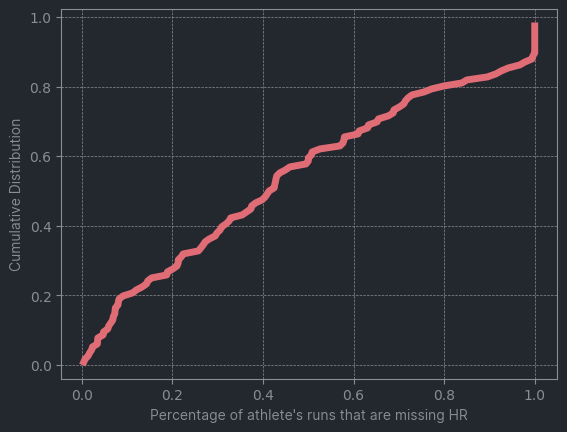

In [25]:
from helpers.my_plotting import my_cumulative

my_cumulative(nullpc_per_athlete, x_name="Percentage of athlete's runs that are missing HR")

##### **Discussion on Heart Rate**
Half of the athletes are missing HR data on >40% of their runs. There is insufficient data to impute the missing values. One option is to omit heart rate from the variables on which the models will be trained.

Alternatively, I could ignore the 56% of data that is missing heart rate, and only keep the remaining data. While I would be throwing away 56% of the data, there are still 26 thousand data points, which could be ample for my application. Heart rate is a very useful metric as it is the only objective variable in the dataset that indicates the level of effort exerted on a run.

On the basis of the importance of heart rate as a indicative parameter, I will choose to exclude all the data without heart rate.

In [26]:
data[data['average heart rate (bpm)'] == 0.0].size/len(data)*100

0.3988982809383607

In [27]:
data = data.dropna(subset=['average heart rate (bpm)']) # drop rows with missing heart rate
print(f"I've now got {data.shape[0]} data points")

I've now got 23732 data points


With the dropped rows, lets see how many runs each athelete has recorded.

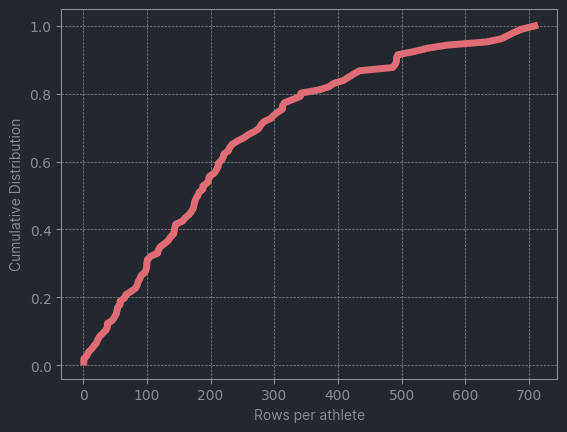

In [28]:
row_per_athlete = data.groupby('athlete').size()
my_cumulative(row_per_athlete, x_name="Rows per athlete")

70% of athletes have at least 100 data points. 

### **Drop Duplicates**

In [29]:
data = data.drop_duplicates()

print(f'There are now {data.shape[0]} rows that are unique')

There are now 23726 rows that are unique


## **Univariate Analysis**

### **Univariate Analysis: Heart Rate**

In [30]:
print(f"Number of rows with 0.0 BPM heart rate: {data[data['average heart rate (bpm)'] == 0.0].size}")
print(f"This is {data[data['average heart rate (bpm)'] == 0.0].size*100/data.shape[0]:.1f}% of the data")

Number of rows with 0.0 BPM heart rate: 168
This is 0.7% of the data


As a rule-of-thumb, I will impute if the missing data is more than 2% but less than 10%. Therefore I will not impute the missing data for heart rate = 0.0 BPM.

In [31]:
data.drop(data[data['average heart rate (bpm)'] == 0.0].index, inplace=True)
print(f"I've now got {data.shape[0]} data points with heart rate data")

I've now got 23702 data points with heart rate data


The world record for the slowest resting heart rate in a healthy human is 27 BPM. Therefore, runs with average heart rate below this value are practically impossible. While the average person would have a resting heart rate of 80 BPM, it is possible for athletes to have resting heart rates as low as 40 BPM.

In [32]:
data[data['average heart rate (bpm)']<40]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km)
806,10825360,2019-12-30 09:34:00,17393.0,12745,807.0,36.9,12.212768
31292,12642956,2019-01-04 14:14:00,2471.0,9327,0.0,26.8,62.909753


The low heart rates above do not appear to be errors, as they are accompanied by extremely slow paces, but I will remove them as these paces will not be beneficial to the dataset. The upper end of the maximum heart rate is not implausible.

In [33]:
data.drop(data[data['average heart rate (bpm)']<40].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23700 data points


In [34]:
hr_sorted = np.sort(data['average heart rate (bpm)'].values)
hr_sorted[:10]

array([41.3, 44.7, 54.1, 54.9, 56.8, 57. , 57.1, 62. , 63.9, 64. ])

The lowest heart rates are still too low for running distances. To determine whether these must be removed, I must look at the data on a per-runner basis in the next step.

The highest heart rate ever recorded in a human is 600 BPM.

In [35]:
data[data['average heart rate (bpm)']>600]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km)


There is no data that exceeds 600 BPM that I can delete on the basis of being implausible.

In [36]:
data["average heart rate (bpm)"].max()

237.0

The highest heart rate in my data is within reason.

#### **Graphical & Numerical Analysis**

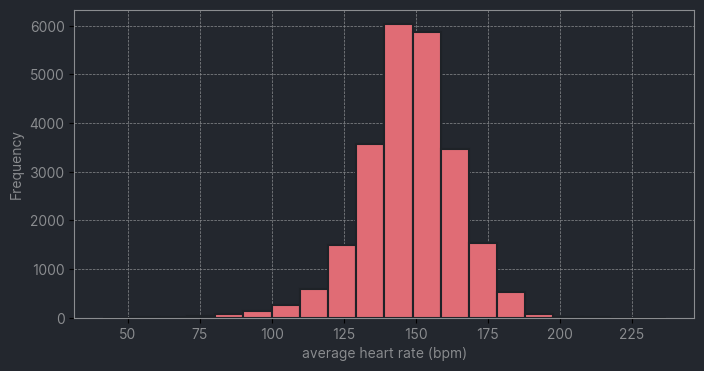

In [37]:
from helpers.my_plotting import my_freqdist

my_freqdist(data['average heart rate (bpm)'])

The data is slightly skewed to the right.

In [38]:
print("skewness: %f" % data['average heart rate (bpm)'].skew())
print("kurtosis: %f" % data['average heart rate (bpm)'].kurt())

skewness: -0.538677
kurtosis: 1.923665


In [39]:
from sklearn.preprocessing import StandardScaler

# standardise the data PER athlete
data['standardised_hr'] = data.groupby('athlete')['average heart rate (bpm)'].transform(lambda x: (x - x.mean()) / x.std())

# flag the row if hr standard deviation is too large
data['flag'] = (data['standardised_hr'] > 5.0) | (data['standardised_hr'] < -3)

data[(data['flag'] == True)]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
334,7191483,2019-01-06 09:02:00,13323.6,3817,134.7,62.0,4.774736,-6.352060,True
821,10825360,2019-11-21 18:10:00,11387.0,3665,160.0,104.6,5.364304,-4.703039,True
823,10825360,2019-11-17 08:41:00,1897.0,795,30.0,106.4,6.984713,-4.571985,True
845,10825360,2019-10-06 07:32:00,1788.0,667,5.0,118.3,6.217375,-3.705567,True
849,10825360,2019-10-05 05:39:00,1512.0,611,0.0,113.9,6.735009,-4.025923,True
...,...,...,...,...,...,...,...,...,...
41257,5035018,2019-01-17 10:32:00,19338.3,12720,1285.8,123.5,10.962701,-3.746396,True
41413,5035018,2018-02-13 19:08:00,1608.0,854,2.4,116.6,8.851575,-4.460997,True
41499,5035018,2017-08-15 19:11:00,1517.1,984,19.1,121.5,10.810098,-3.953527,True
41501,5035018,2017-08-15 17:42:00,1547.7,702,2.2,124.3,7.559605,-3.663544,True


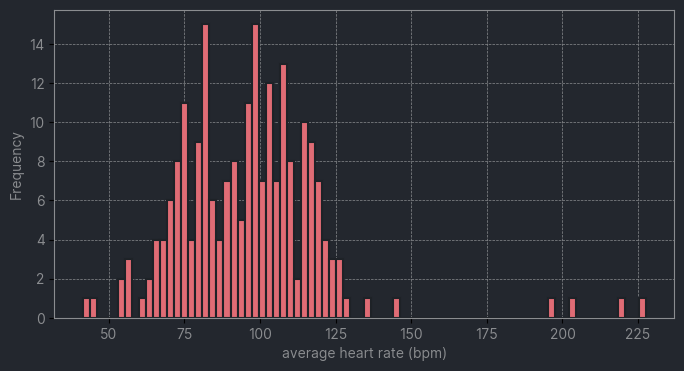

In [40]:
my_freqdist(data[(data['flag'] == True)]["average heart rate (bpm)"], n_bins=80)

Drop the rows that have an outlier heart rate, considering each athlete's individual mean heart rate.

In [41]:
data.drop(data[data['flag'] == True].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23481 data points


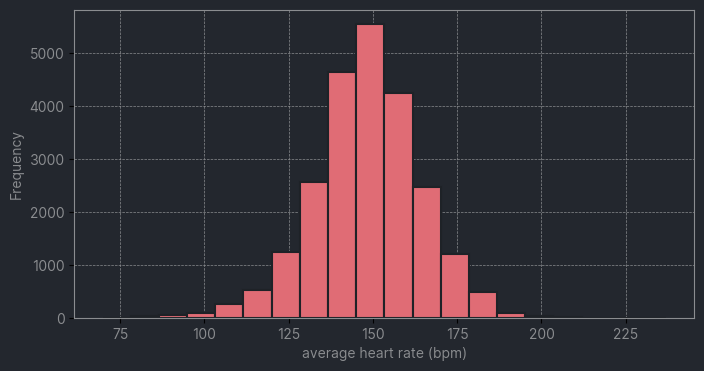

In [42]:
my_freqdist(data['average heart rate (bpm)'])

### **Univariate Analysis: Distance**

From the previous step, I know that no distance values are missing. Let's check if any distance values are 0.

In [43]:
data[data["elevation gain (m)"] == 0]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
114,18042525,2018-01-09 19:46:00,2126.2,726,0.0,123.0,5.690904,-1.630601,False
161,18042525,2017-05-04 16:09:00,9539.6,2972,0.0,143.4,5.192391,-0.026524,False
163,18042525,2017-04-27 16:37:00,6177.7,1679,0.0,158.0,4.529733,1.121492,False
167,18042525,2017-04-17 15:17:00,5160.3,1405,0.0,154.0,4.537850,0.806967,False
170,18042525,2017-03-31 16:49:00,5253.1,1419,0.0,158.7,4.502104,1.176534,False
...,...,...,...,...,...,...,...,...,...
41292,5035018,2018-11-14 18:47:00,447.5,204,0.0,151.3,7.597765,-0.867276,False
41304,5035018,2018-10-17 17:43:00,548.6,215,0.0,150.3,6.531778,-0.970842,False
41519,5035018,2017-07-02 08:36:00,1483.1,431,0.0,161.2,4.843459,0.158022,False
41559,5035018,2017-03-20 12:40:00,2725.1,803,0.0,161.9,4.911135,0.230517,False


In [44]:
print(f'There are {data[data["distance (m)"] == 0].shape[0]} rows without distance data')
print(f'All rows missing distance are also missing elevation: {np.all(data[data["distance (m)"] == 0] == data[(data["distance (m)"] == 0) & (data["elevation gain (m)"] == 0)])}')
data[(data["distance (m)"] == 0) & (data["elapsed time (s)"] < 10)]

There are 22 rows without distance data
All rows missing distance are also missing elevation: True


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
8032,6215611,2018-04-21 14:32:00,0.0,4,0.0,111.3,inf,-1.680656,False
13893,12740383,2019-12-18 06:38:00,0.0,2,0.0,119.0,inf,-1.868945,False
40981,5688059,2014-01-21 20:10:00,0.0,4,0.0,123.0,inf,-1.986620,False
40986,5688059,2014-01-15 19:42:00,0.0,4,0.0,114.0,inf,-2.644202,False


Many of the rows without distance also have unrealistically short elapsed time. All of the rows without distance are also missing elevation gain. As the rows missing distance are also missing other data, I'll delete them instead of imputing the missing data. This will prevent the creation of data points that are too artificial.

In [45]:
data.drop(data[data["distance (m)"] == 0.0].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23459 data points


**Remove sprint distances, too** - these could distort the model by creating a more complicated 'surface'

Above distances of 1500m (~1 mile), there is a significantly higher proportion of aerobic activity compared to shorter distances. Anecdotally, this is also the distance above which most non-runners cannot complete while running throughout. Therefore, I'll use this as our cut-off point. 

<[source](https://readysetmarathon.com/what-is-considered-distance-running/)>


In [46]:
data.drop(data[data["distance (m)"] < 1500].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23017 data points


In [47]:
print(f'Longest distance: {data["distance (m)"].max()}')
data[data["distance (m)"] == data["distance (m)"].max()]

Longest distance: 218950.0


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
16127,17639804,2018-10-18 19:59:00,218950.0,96372,9729.0,134.0,7.335921,-1.099759,False


The data row with the longest distance is implausible. The elapsed time is greater than a day, and the elevation gain is greater than Mount Everest. I'll go through time and elevation later on, so I'll leave this row in here for now.

### **Univariate Analysis: Elevation**

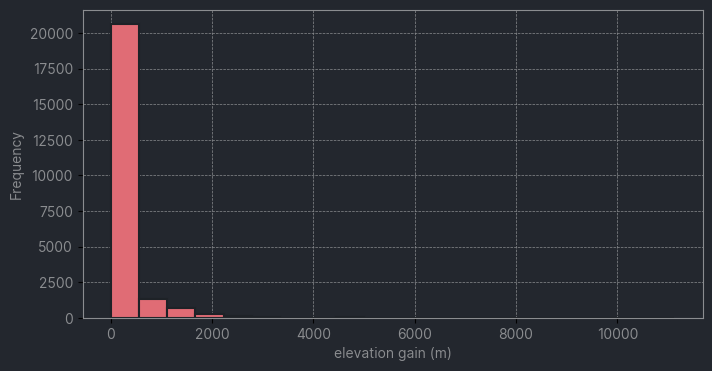

In [48]:
my_freqdist(data["elevation gain (m)"])

Elevation can't be eliminated on the basis of standard deviation. Outliers of elevation can still be perfectly valid. Therefore, I must eliminate based on what is actually possible and what is productive towards creating a good generalisable dataset.

In [49]:
print(f'Highest elevation gain: {data["elevation gain (m)"].max()} m')
print(f'{data[data["elevation gain (m)"] > 8849].shape[0]} rows with elevation gain higher than Mount Everest')

Highest elevation gain: 11128.0 m
2 rows with elevation gain higher than Mount Everest


The highest elevation gain in the data is 11,128 m. This is taller than Mount Everest, which is "only" 8,849 m high. I'll delete the row

In [50]:
data.drop(data[data["elevation gain (m)"] > 8849].index, inplace=True)

To assess whether a high elevation gain is valid, I'll do some **feature engineering** and construct a new feature: **gradient**, which is elevation divided by distance, expressed as a percentage.

In [51]:
data["gradient (%)"] = (data["elevation gain (m)"]/data["distance (m)"])*100
data[data["elevation gain (m)"] > 5000]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
1031,10825360,2018-08-25 03:03:00,84278.0,52978,5450.0,157.5,10.476835,-0.851487,False,6.466694
13979,12740383,2019-06-28 02:00:00,90281.0,55226,5736.0,141.0,10.195205,-0.448842,False,6.353496
16161,17639804,2018-08-25 03:03:00,84149.3,47334,5245.0,146.4,9.375004,-0.104441,False,6.232969
40687,5688059,2016-05-06 03:08:00,126145.0,66815,7547.7,131.3,8.827804,-1.380183,False,5.983352


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='elevation gain (m)', ylabel='gradient (%)'>)

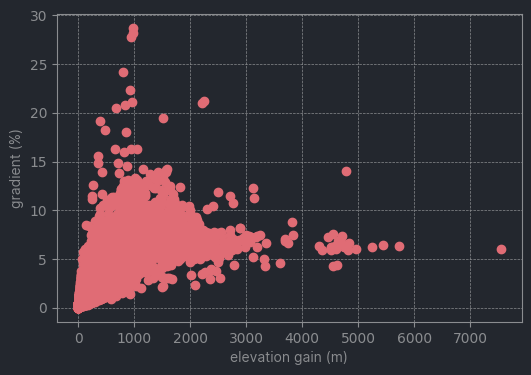

In [52]:
from helpers.my_plotting import my_xyscatter

my_xyscatter(data["elevation gain (m)"], data["gradient (%)"])

From the graphical analysis above, I can see that the data points with very high elevation gain also have fairly normal gradient. The data points with very high gradient do not have implausible elevation. Therefore, I don't have data to eliminate on the basis of high elevation.

In [53]:
data[data["elevation gain (m)"] == 0.0]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
114,18042525,2018-01-09 19:46:00,2126.2,726,0.0,123.0,5.690904,-1.630601,False,0.0
161,18042525,2017-05-04 16:09:00,9539.6,2972,0.0,143.4,5.192391,-0.026524,False,0.0
163,18042525,2017-04-27 16:37:00,6177.7,1679,0.0,158.0,4.529733,1.121492,False,0.0
167,18042525,2017-04-17 15:17:00,5160.3,1405,0.0,154.0,4.537850,0.806967,False,0.0
170,18042525,2017-03-31 16:49:00,5253.1,1419,0.0,158.7,4.502104,1.176534,False,0.0
...,...,...,...,...,...,...,...,...,...,...
41098,5035018,2019-11-13 18:12:00,2801.0,624,0.0,151.7,3.712960,-0.825850,False,0.0
41137,5035018,2019-09-18 17:23:00,1843.0,709,0.0,155.8,6.411648,-0.401232,False,0.0
41284,5035018,2018-12-05 18:12:00,5087.7,1245,0.0,164.1,4.078464,0.458361,False,0.0
41559,5035018,2017-03-20 12:40:00,2725.1,803,0.0,161.9,4.911135,0.230517,False,0.0


In [54]:
print('There are {} rows with 0.0 elevation'.format(len(data[data["elevation gain (m)"] == 0.0])))

There are 1006 rows with 0.0 elevation


There is no way to tell if a data point with 0.0 elevation is truly invalid, so I won't delete any of these data points.

### **Univariate Analysis: Pace**

This is an engineered feature that indicates how fast an athlete was running on average.

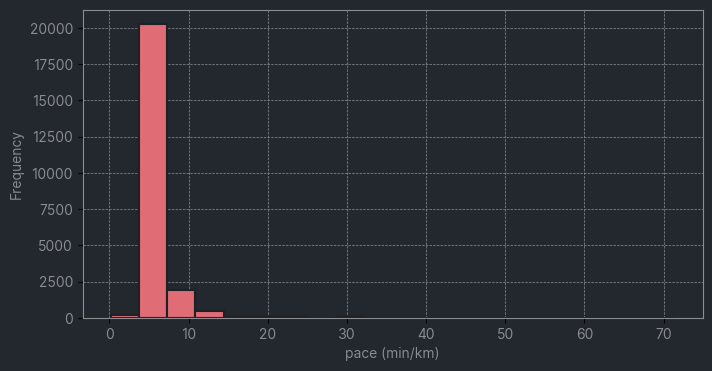

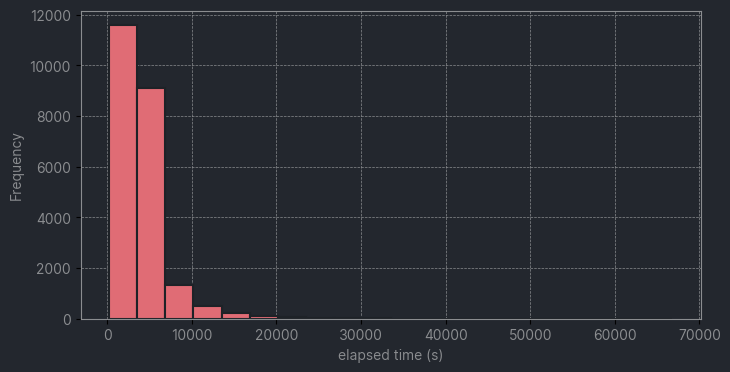

In [55]:
my_freqdist(data["pace (min/km)"])
my_freqdist(data["elapsed time (s)"])

Slow average pace are still valid and can still appear in the deployed incoming data, so I will leave these values in. However, I can eliminate paces that are impossibly fast as these are invalid.

In [56]:
print(f'Fastest pace {data["pace (min/km)"].min():.5f} min/km')
print(f'Slowest pace {data["pace (min/km)"].max():.5f} min/km')
print(f"World record 100m pace (Usain Bolt): {9.58/60/0.1:.5f} min/km")
print(f"World record 60m pace (Christian Coleman): {6.34/60/0.06:.5f} min/km")

Fastest pace 0.17581 min/km
Slowest pace 71.37915 min/km
World record 100m pace (Usain Bolt): 1.59667 min/km
World record 60m pace (Christian Coleman): 1.76111 min/km


In [57]:
print(f"Implausibly fast rows: {data[data['pace (min/km)'] < 1.59].size}")
print(f"Percentage of total: {data[data['pace (min/km)'] < 1.59].size/data.shape[0]*100:.2f} %")
data[data["pace (min/km)"] < 1.59]

Implausibly fast rows: 50
Percentage of total: 0.22 %


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
11128,3460571,2019-05-26 07:09:00,33105.1,2752,935.6,144.4,1.385486,0.460520,False,2.826151
12261,2913078,2016-10-17 17:03:00,2130.7,189,0.0,127.8,1.478387,-0.630577,False,0.000000
13953,12740383,2019-08-23 23:22:00,41746.6,2001,2513.0,123.6,0.798867,-1.572014,False,6.019652
19643,18736169,2019-02-05 16:59:00,10683.0,399,47.6,135.3,0.622484,-0.793141,False,0.445568
37941,22891135,2018-06-23 04:31:00,36593.1,386,347.4,144.7,0.175807,-0.394992,False,0.949359


As before, I stated that I would impute data if the affected rows were more than 2% but less than 10%. Therefore, I will delete these data points instead of imputing them.

In [58]:
data.drop(data[data["pace (min/km)"] < 1.59].index, inplace=True)

I can also delete paces that exceed the world record pace for long distances. For each race distance, I'll delete rows that have both a distance greater than that distance and a time shorter than the world record time for that distance.

In [59]:
fastest_distances = {
    '50k':
        {
            'time': 2*3600+40*60+13, 
            'distance': 50000
        },
    'marathon': 
        {
            'time': 2*3600+35, 
            'distance': 42195
        }, 
    'half': 
        {
            'time': 57*60+31, 
            'distance': 42195/2
        }, 
    '15k': 
        {
            'time': 44*60+14, 
            'distance': 15000
        }, 
    '12k': 
        {
            'time': 35*60+57, 
            'distance': 12000
        }, 
    '10k': 
        {
            'time': 26*60+11, 
            'distance': 10000
        }, 
    '8k': 
        {
            'time': 22*60+39, 
            'distance': 8000
        }, 
    '5k': 
        {
            'time': 13*60+38, 
            'distance': 5000
        }, 
    '1500m': 
        {
            'time': 3*60+26, 
            'distance': 1500
        }
    }

In [60]:
def valid_pace(row):

    for field in fastest_distances:
        if ((row['distance (m)'] > fastest_distances[field]['distance']) & (row['elapsed time (s)'] < fastest_distances[field]['time'])):
            return True

data["flag"] = data.apply(valid_pace, axis=1)
data[data["flag"]==True]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
6716,7947798,2015-11-18 18:36:00,1868.8,202,0.0,157.7,1.801513,1.802741,True,0.000000
12194,2913078,2017-02-04 16:24:00,1579.7,184,0.0,91.9,1.941297,-2.253710,True,0.000000
19644,18736169,2019-02-04 17:45:00,15906.0,1914,211.9,126.8,2.005533,-1.324577,True,1.332202
29568,2138770,2018-10-16 11:38:00,43630.2,6673,453.2,139.3,2.549075,-0.420376,True,1.038730
29580,2138770,2018-09-03 14:52:00,67299.7,7953,584.0,134.6,1.969548,-0.712452,True,0.867760
31278,12642956,2019-01-27 08:07:00,15070.0,1926,159.0,164.3,2.130060,0.487835,True,1.055076
31808,11284478,2017-05-26 06:30:00,22841.0,2537,1175.0,163.3,1.851203,0.832833,True,5.144258


In [61]:
data.drop(data[data['flag'] == True].index, inplace=True)

### **Univariate Analysis: Timestamp**

I'll do more feature engineering and construct another feature that indicates the time since the data point was performed. This is because runs that are more recent will be more indicative of future performance.

In [62]:
# Calculate the amount of time since that run - the datum doesn't matter 

data["time ago (s)"] = datetime(2023, 1, 1) - data["timestamp"]

data["time ago (s)"] = data["time ago (s)"].apply(lambda x: x.total_seconds())

data.head()

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%),time ago (s)
0,18042525,2019-12-15 09:08:00,2965.8,812,17.4,150.3,4.563131,0.516032,None,0.586688,96130320.0
1,18042525,2019-12-10 19:27:00,10020.8,3290,52.2,160.8,5.471952,1.341660,None,0.520916,96525180.0
2,18042525,2019-12-03 19:46:00,12132.2,4027,249.0,148.9,5.532110,0.405948,None,2.052390,97128840.0
3,18042525,2019-11-26 19:46:00,11631.5,4442,194.0,136.2,6.364900,-0.592669,None,1.667885,97733640.0
4,18042525,2019-11-19 19:45:00,11708.1,4022,250.7,146.0,5.725381,0.177917,None,2.141253,98338500.0


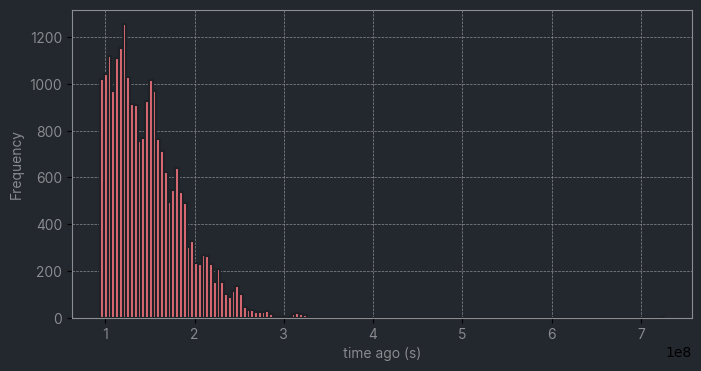

In [63]:
my_freqdist(data["time ago (s)"],n_bins=150)

In [64]:
print(f'Newest data point: {max(data["timestamp"])}')
print(f'Oldest data point: {min(data["timestamp"])}')

Newest data point: 2020-01-06 05:24:00
Oldest data point: 2000-01-04 12:06:00


The timestamp column has no problems.

## **Feature Scaling**

### **Frequency Distributions & Transformation**

In [65]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson

#### **Elevation**

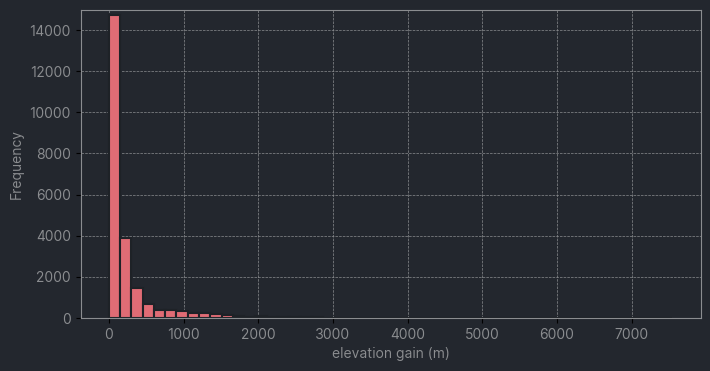

Skewness: 4.31
Kurtosis: 29.22


In [66]:
x = data["elevation gain (m)"]

my_freqdist(x,n_bins=50, ylim=[0,15000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

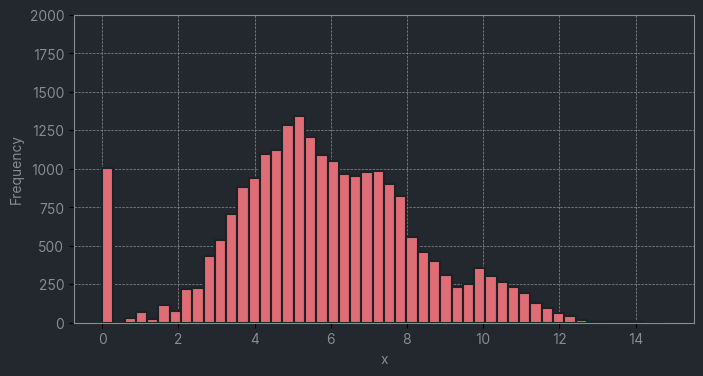

Skewness: 0.01
Kurtosis: 0.23


In [67]:
from scipy.stats import boxcox

x = boxcox(data["elevation gain (m)"]+1)[0]

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

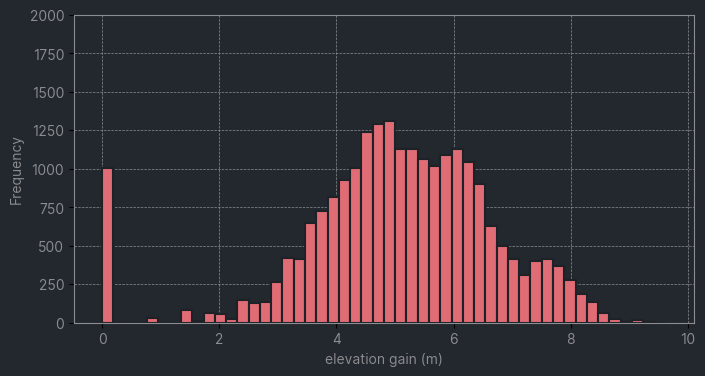

Skewness: -0.84
Kurtosis: 1.46


In [68]:
x = np.arcsinh(data["elevation gain (m)"])

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

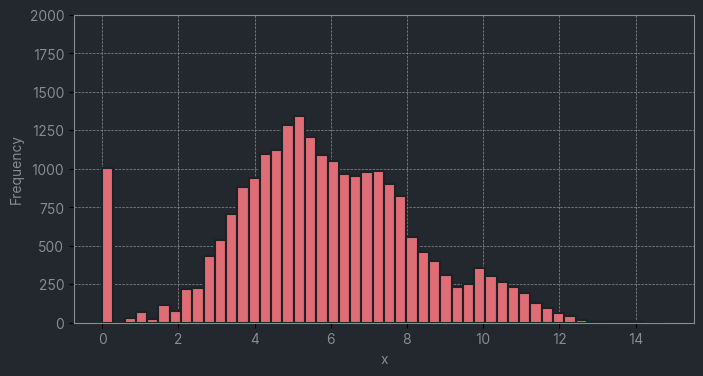

Skewness: 0.01
Kurtosis: 0.23


In [69]:
x = yeojohnson(data["elevation gain (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will use Yeo-Johnson to scale Elevation

In [70]:
data["elevation"] = yeojohnson(data["elevation gain (m)"])[0]

#### **Distance**

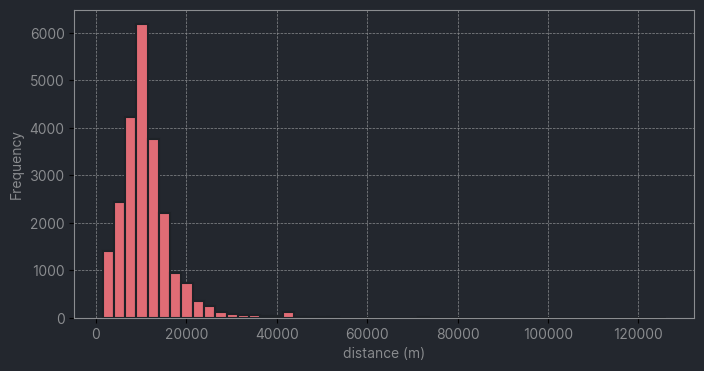

Skewness: 3.39
Kurtosis: 26.19


In [71]:
x = data['distance (m)']

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

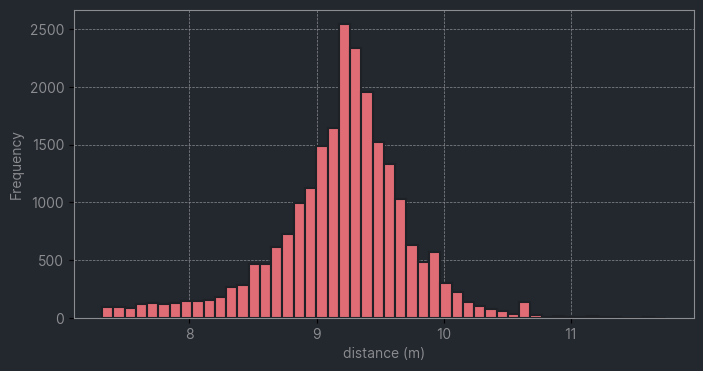

Skewness: -0.56
Kurtosis: 1.73


In [72]:
x = np.log(data["distance (m)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

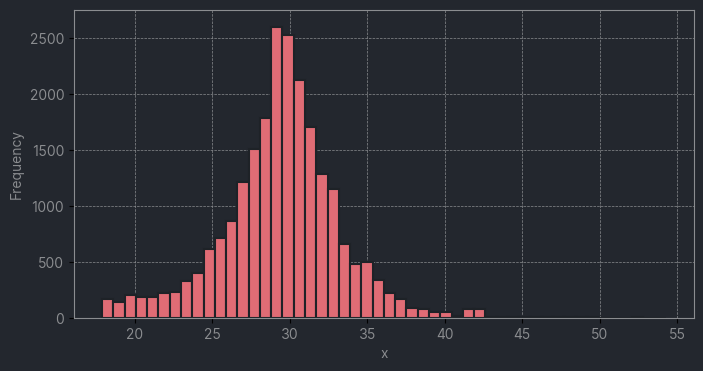

Skewness: 0.07
Kurtosis: 1.90


In [73]:
x = boxcox(data["distance (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2750])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

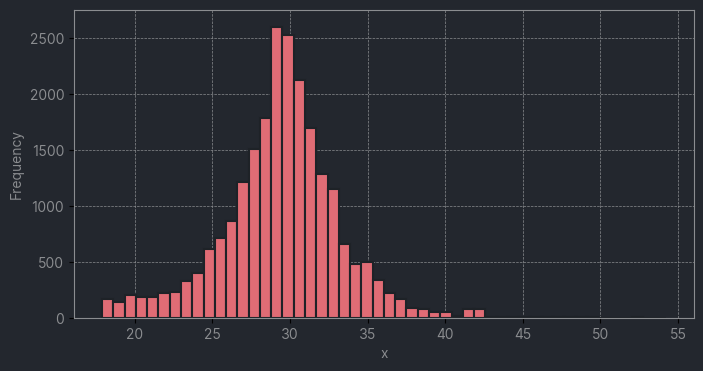

Skewness: 0.07
Kurtosis: 1.90


In [74]:
x = yeojohnson(data["distance (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2750])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will use Yeo-Johnson to scale Distance.

In [75]:
data["distance"] = yeojohnson(data["distance (m)"])[0]

#### **Heart Rate**

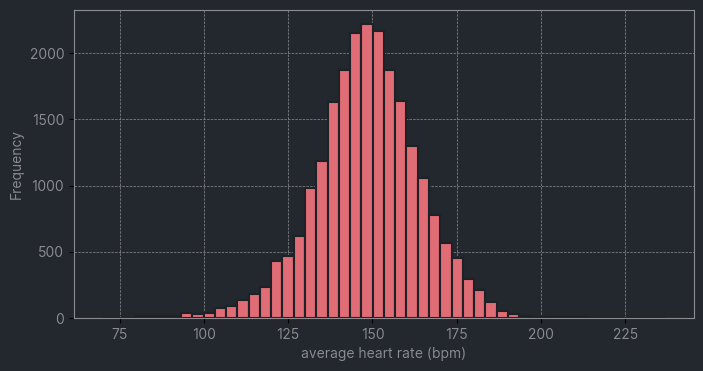

Skewness: -0.22
Kurtosis: 0.94


In [76]:
x = data['average heart rate (bpm)']

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

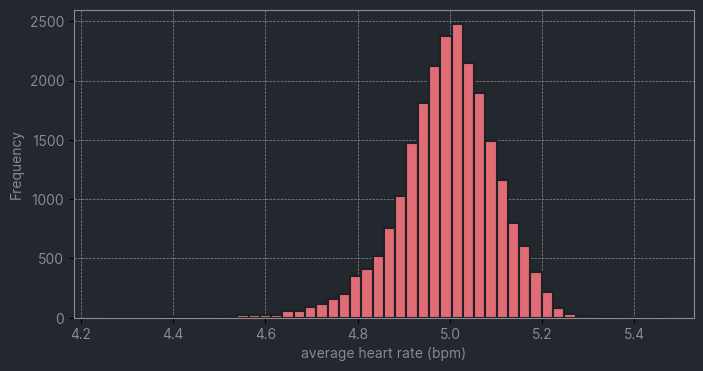

Skewness: -0.74
Kurtosis: 2.11


In [77]:
x = np.log(data['average heart rate (bpm)'])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Heart Rate does not need to be transformed as it is already highly normally distributed.

In [78]:
data["hr"] = data['average heart rate (bpm)']

#### **Time Ago**

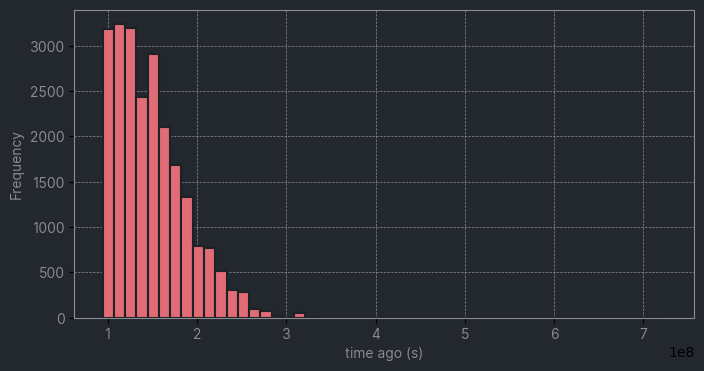

Skewness: 1.09
Kurtosis: 2.67


In [79]:
x = data["time ago (s)"]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

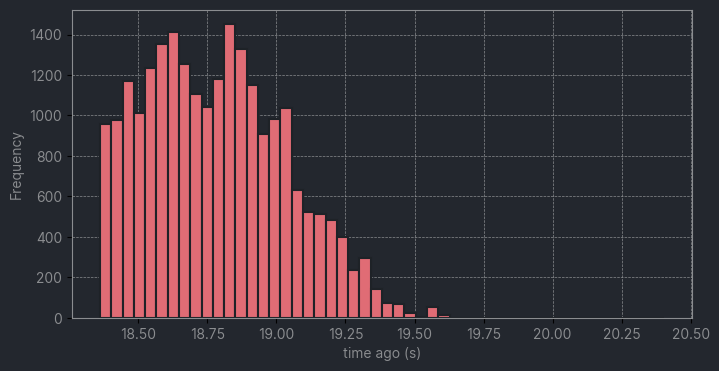

Skewness: 0.41
Kurtosis: -0.44


In [80]:
x = np.log(data["time ago (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

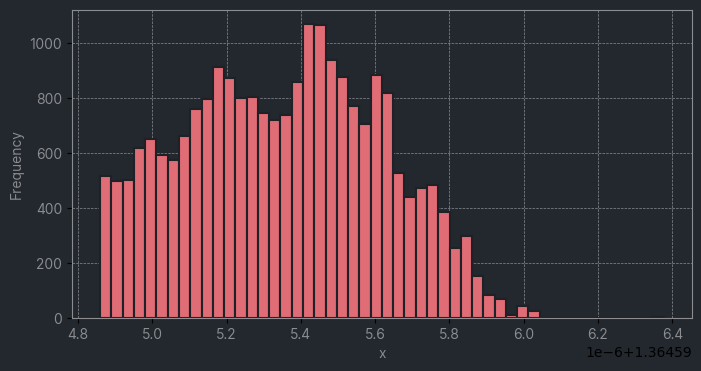

Skewness: 0.00
Kurtosis: -0.84


In [81]:
x = boxcox(data["time ago (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

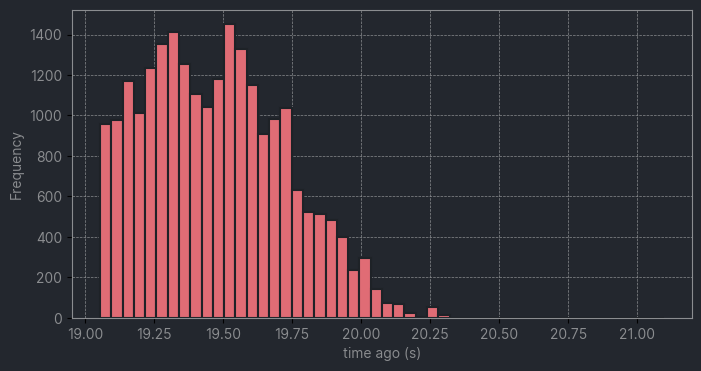

Skewness: 0.41
Kurtosis: -0.44


In [82]:
x = np.arcsinh(data["time ago (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

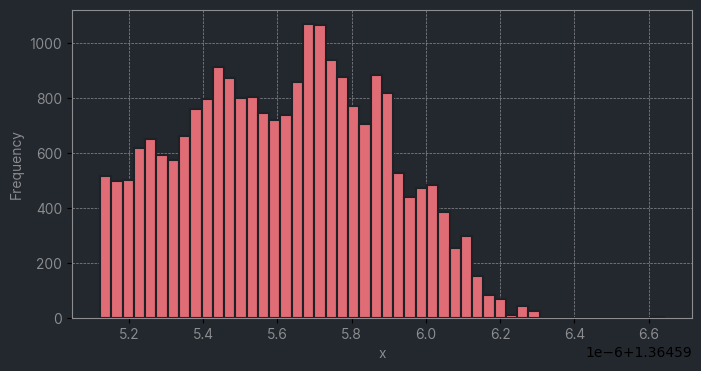

Skewness: 0.00
Kurtosis: -0.84


In [83]:
x = yeojohnson(data["time ago (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will also use Yeo-Johnson to scale Time-Ago

In [84]:
data["time_ago"] = yeojohnson(data["time ago (s)"])[0]

#### **Time**

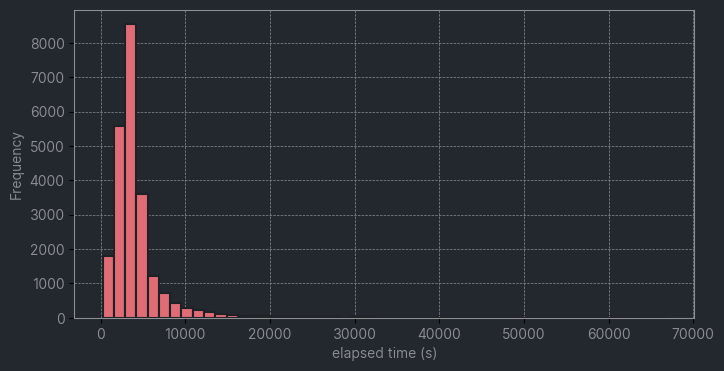

Skewness: 5.08
Kurtosis: 46.11


In [85]:
x = data["elapsed time (s)"]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

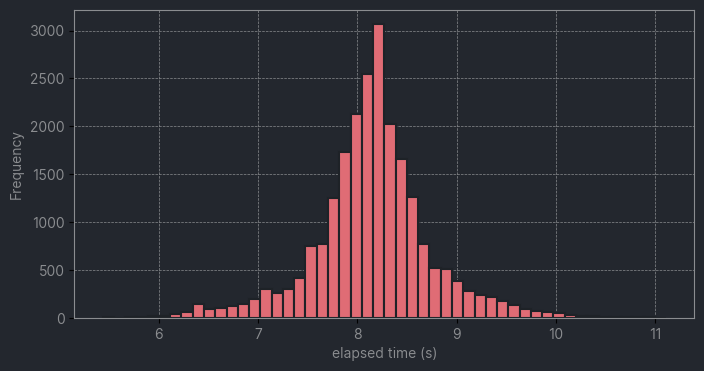

Skewness: -0.04
Kurtosis: 2.07


In [86]:
x = np.log(data["elapsed time (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

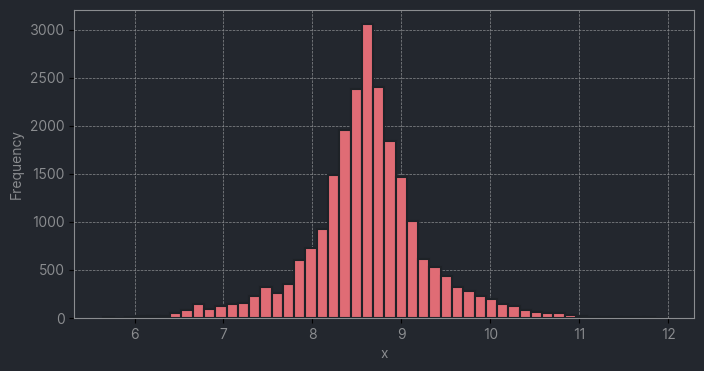

Skewness: 0.01
Kurtosis: 2.08


In [87]:
x = yeojohnson(data["elapsed time (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

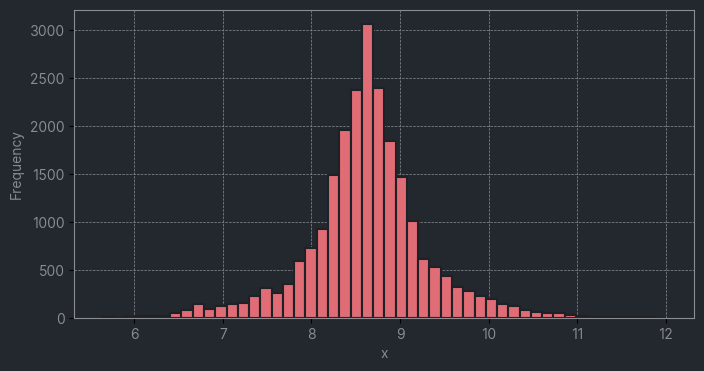

Skewness: 0.01
Kurtosis: 2.08


In [88]:
x = boxcox(data["elapsed time (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Yeo-Johnson and BoxCox perform identically. For consistency's sake, I'll use Yeo-Johnson to scale Time.

### **Summary of Transformations and Variables**

| **Variable** | **Type** | **Transform** |
|--------------|----------|---------------|
| Distance     | Input    | Yeo-Johnson    |
| Elevation    | Input    | Yeo-Johnson    |
| HR           | Input    | None           |
| Time-Ago     | Input    | Yeo-Johnson    |
| Time         | Output   | Yeo-Johnson    |


### **Scaling**

In [89]:
from sklearn.preprocessing import MinMaxScaler

## **Pre-Visualising the Relationshing**

Let's plot 3 variables against each other as the 3D space will allow us to easily visualise the correlations.

In [90]:
from helpers.my_plotting import my_scatter

athletes = data["athlete"].unique()
athlete_idx = 6

my_scatter(x=data.loc[data["athlete"] == athletes[athlete_idx]]["average heart rate (bpm)"],
           y=data.loc[data["athlete"] == athletes[athlete_idx]]["distance (m)"],
           z=data.loc[data["athlete"] == athletes[athlete_idx]]["elapsed time (s)"],
           c=data.loc[data["athlete"] == athletes[athlete_idx]]["time ago (s)"],
           height=600)

In [91]:
my_scatter(x=data.loc[data["athlete"] == athletes[athlete_idx]]["average heart rate (bpm)"],
           y=data.loc[data["athlete"] == athletes[athlete_idx]]["distance (m)"],
           z=data.loc[data["athlete"] == athletes[athlete_idx]]["pace (min/km)"],
           c=data.loc[data["athlete"] == athletes[athlete_idx]]["gradient (%)"],
           height=600)

Plotting Pace instead of Time shows that Time is a much more predictable variable to correlate, and that I was correct in using Time as a predictor instead of Pace.

Now that the data is processed and normalised, I'll create an initial Neural Network (NN) to see the minimum number of nodes to capture the input/output map with at least 90% accuracy for a given user. This will allow me to decide whether a helper model for fine-tuning is feasible.

The possible outcomes will be:
* Low number of nodes: the output of the helper fine-tuning model can be the changes to weights and biases for each node
* High number of nodes: there are too many weights and biases to create a neural network with these as outputs - I'll have to fine tune base models directly, and probably use a greater number of clusters 
* Accuracy can't be captured with 90% accuracy: this indicates that there is poor correlation of the input with the output

## **EDA Conclusion**

The EDA has now been completed. The data is cleaned, transformed and scaled.

In [92]:
data.to_csv("cleaned_data.csv", index_label='index')

In [93]:
data = pd.read_csv("cleaned_data.csv", index_col='index')

# **Model Strategy**

Each athlete has 1 model etc.

# **Train-Test Split**

I will split my data not randomly, but according to how much many runs each athlete has. The athletes with too few runs to be useful will be used for testing.

don't transform entire datasets. Transform for each base model

In [94]:
len(data["athlete"].unique())

106

In [95]:
athlete_counts = data['athlete'].value_counts()
data['row_count'] = data['athlete'].map(athlete_counts)
print(f"There are {data.drop_duplicates(subset='athlete').sort_values(by='row_count')[data['row_count']<30].shape[0]} athletes with fewer than 30 data points")


There are 10 athletes with fewer than 30 data points


C:\Users\hobly\AppData\Local\Temp\ipykernel_492\2565965533.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [96]:
data.drop_duplicates(subset='athlete')[['athlete', 'row_count']].sort_values(by='row_count').head(10)

,athlete,row_count
index,,
38422,25277048,1
37284,20557028,1
29069,28252317,6
36933,38870390,8
280,20263706,13
7119,22972731,17
19328,39076296,20
12938,27479582,22
38504,6583234,23


In [97]:
ath_mostruns = data.drop_duplicates(subset='athlete')[data["row_count"]==data["row_count"].max()]["athlete"].values[0]

data[data["athlete"]==ath_mostruns].sort_values(by='average heart rate (bpm)', ascending=False)


C:\Users\hobly\AppData\Local\Temp\ipykernel_492\2129297842.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%),time ago (s),elevation,distance,hr,time_ago,row_count
index,,,,,,,,,,,,,,,,
39389,19023831,2019-01-18 05:16:00,8431.5,2506,18.7,188.4,4.953646,4.199279,NaN,0.221787,124742640.0,3.499298,28.112991,188.4,1.364595,689
39607,19023831,2018-03-21 08:23:00,8534.5,2520,100.8,187.0,4.921202,4.082550,NaN,1.181089,150910620.0,5.949740,28.199210,187.0,1.364596,689
39714,19023831,2017-10-02 03:42:00,8997.4,3026,67.6,184.9,5.605323,3.907456,NaN,0.751328,165615480.0,5.321720,28.576920,184.9,1.364596,689
39516,19023831,2018-07-25 05:35:00,6863.5,2303,47.0,182.0,5.592385,3.665661,NaN,0.684782,140034300.0,4.775544,26.685934,182.0,1.364596,689
39202,19023831,2019-10-24 04:26:00,10314.4,3055,38.0,179.7,4.936464,3.473892,NaN,0.368417,100640040.0,4.467239,29.574088,179.7,1.364595,689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,19023831,2018-01-07 10:10:00,4010.0,1145,14.7,110.2,4.758936,-2.320867,NaN,0.366584,157211400.0,3.192680,23.245431,110.2,1.364596,689
39598,19023831,2018-04-07 08:23:00,5038.9,1359,21.4,109.4,4.495029,-2.387569,NaN,0.424696,149441820.0,3.676085,24.658745,109.4,1.364596,689
39513,19023831,2018-07-29 08:03:00,2029.6,962,9.7,107.1,7.899750,-2.579338,NaN,0.477927,139679820.0,2.690989,19.424414,107.1,1.364596,689


In [98]:
race_idx_19023831 = 39202 # index in data df for a race by athlete 19023831

In [99]:
from helpers.my_plotting import my_iteractable_cumulative

my_iteractable_cumulative(data["row_count"].drop_duplicates())

In [100]:
train_athletes = data[data["row_count"]>=200].sort_values("row_count", ascending=False)["athlete"].drop_duplicates().values.tolist()

print(f'{len(train_athletes)} athletes will be used to train models')

test_athletes = data[data["row_count"]<200].sort_values("row_count", ascending=False)["athlete"].drop_duplicates().values.tolist()

print(f'{len(test_athletes)} athletes will be used to test models')

46 athletes will be used to train models
60 athletes will be used to test models


I want to avoid activation functions such as Sigmoid, Softmax, ReLU and Tanh, especially in the output layer, as these have a fixed maximum and minimum. This is because it is very possible that data could be received that is outside the range of the original train set.

In [101]:
from helpers.distance_running import LeakyReLU_NN, athlete_data
from helpers.distance_running import INPUT_COLS as INPUT_COLS

INPUT_COLS

['distance (m)',
 'elevation gain (m)',
 'average heart rate (bpm)',
 'time ago (s)']

In [102]:
data19023831 = athlete_data(athletes = [ath_mostruns], race_idx = race_idx_19023831, device = "cpu")

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:104: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)



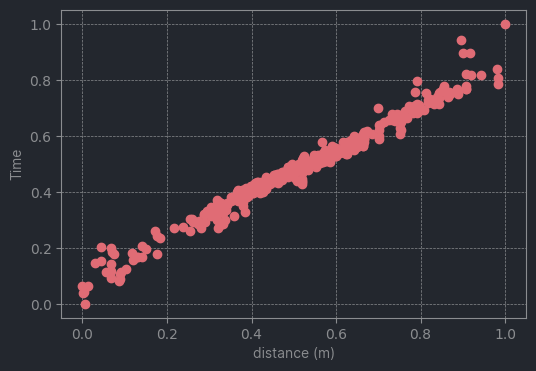

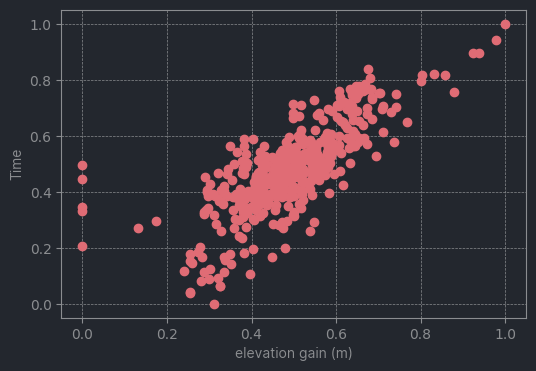

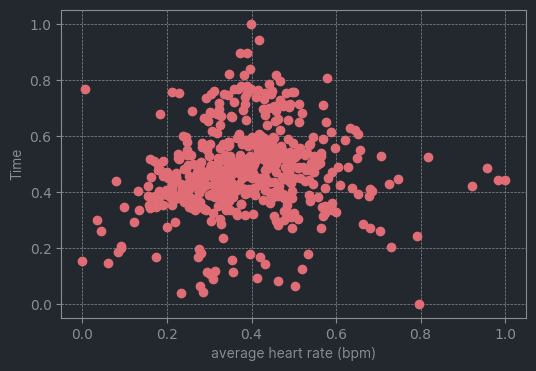

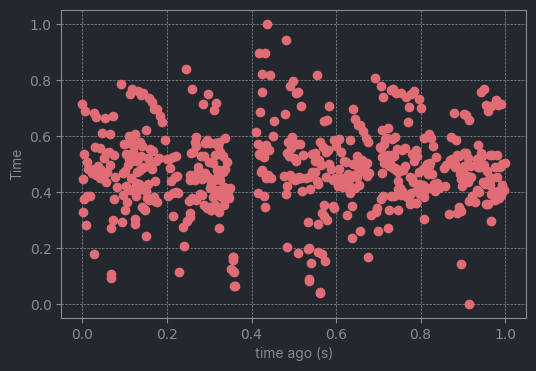

In [103]:
for k in range(len(INPUT_COLS)):
    my_xyscatter(data19023831.x_train_vals[:,k], data19023831.y_train_vals.reshape(-1),
                x_name=INPUT_COLS[k], y_name='Time')

The above graphs show that time_ago and HR are poor indicators of the time variable. Therefore, I'll check if pace is a better y variable than time. HR should better indicate pace, but time_ago will likely still be poorly correlated. Therefore, this value should either be dropped as an input variable, or an RNN/LSTM should be used to capture the passage of time between runs.

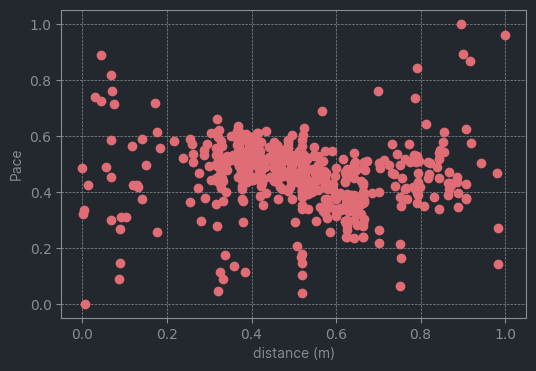

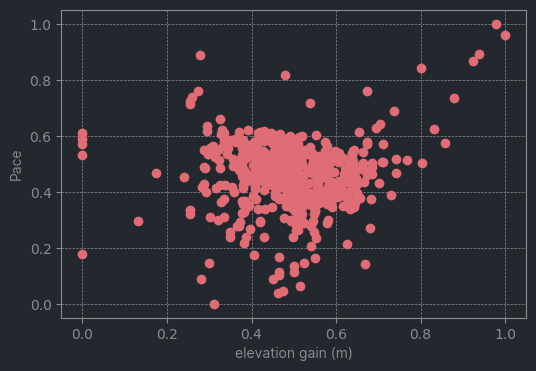

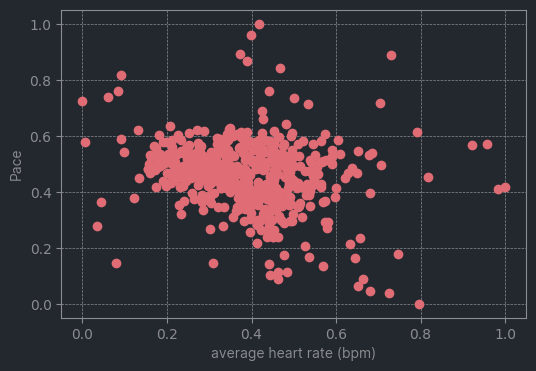

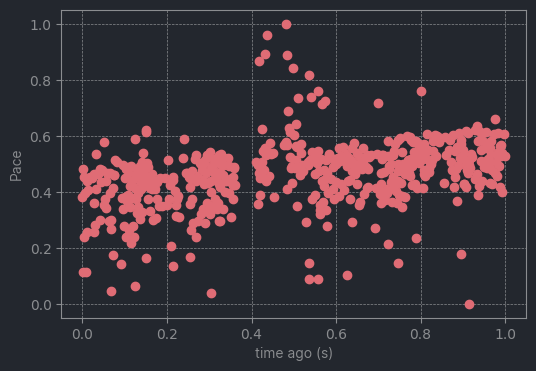

In [104]:
for k in range(len(INPUT_COLS)):
    my_xyscatter(data19023831.x_train_vals[:,k], data19023831.pace_scaled.reshape(-1),
                x_name=INPUT_COLS[k], y_name='Pace')

In [105]:
from helpers.distance_running import mape_actualtime, model_handler, find_hn_epochs

To optimise the number of hidden nodes and epochs, I want to use MAPE as the evaluation metric. The models will still be trained with MSE as the loss criterion. 

The code below identifies the number of hidden nodes that achieves the lowest MAPE loss across the full range of epochs between 1 and 500. I will then select the combination of hidden nodes and epochs that produced the lowest MAPE loss.

In [106]:
import pickle

In [107]:
finder_basic = find_hn_epochs(
    model_class=LeakyReLU_NN, 
    start_hn=2, 
    stop_hn=30, 
    dataobject=data19023831
    )

finder_basic.find(save_best=True, target_folder='finder_basic')

with open('finder_basic/finder_basic.pkl', 'wb') as output:
    pickle.dump(finder_basic, output, pickle.HIGHEST_PROTOCOL)

67.9% complete | Estimated time remaining = 2.39 minutes
Epoch 001 | Average training loss: 0.09640 | Average testing loss: 0.00072
Epoch 002 | Average training loss: 0.02871 | Average testing loss: 0.00078
Epoch 003 | Average training loss: 0.02070 | Average testing loss: 0.00079
Epoch 004 | Average training loss: 0.01654 | Average testing loss: 0.00077
Epoch 005 | Average training loss: 0.01381 | Average testing loss: 0.00079
Epoch 006 | Average training loss: 0.01234 | Average testing loss: 0.00081
Epoch 007 | Average training loss: 0.01139 | Average testing loss: 0.00082
Epoch 008 | Average training loss: 0.01058 | Average testing loss: 0.00083
Epoch 009 | Average training loss: 0.00983 | Average testing loss: 0.00083
Epoch 010 | Average training loss: 0.00941 | Average testing loss: 0.00084
Epoch 011 | Average training loss: 0.00917 | Average testing loss: 0.00085
Epoch 012 | Average training loss: 0.00892 | Average testing loss: 0.00085
Epoch 013 | Average training loss: 0.00865 

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


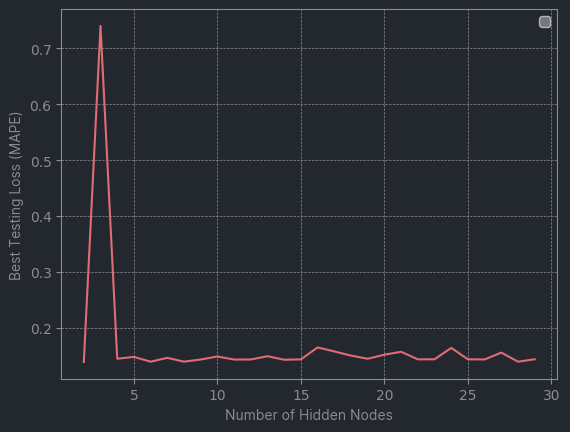

In [ ]:
with open('finder_basic/finder_basic.pkl', 'rb') as input:
    finder_basic = pickle.load(input)

finder_basic.plot_result()

The plot above shows that above 6 hidden nodes, there is little benefit to increasing the number of hidden nodes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


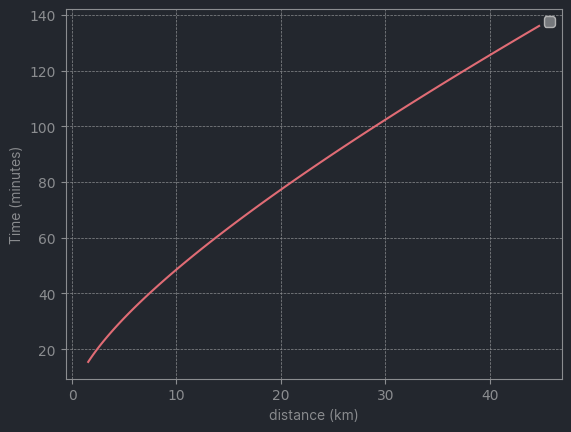

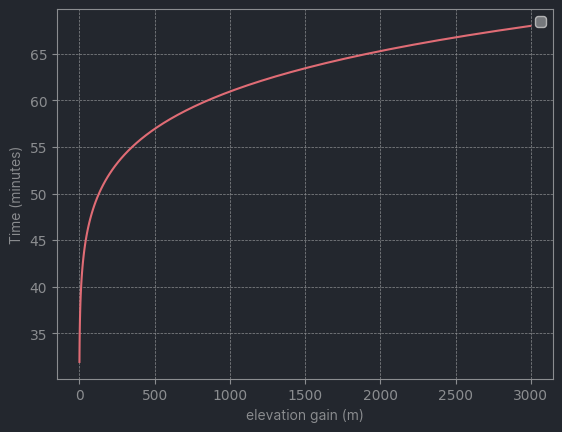

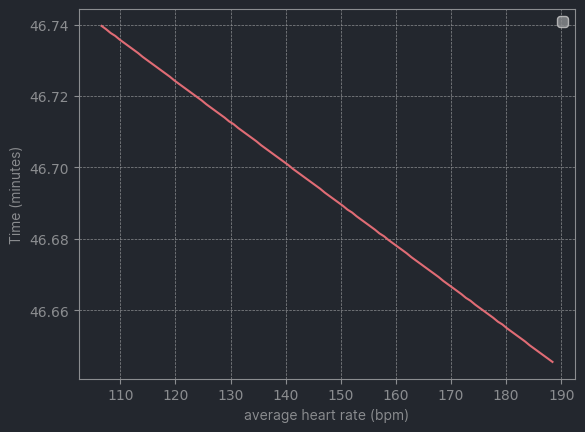

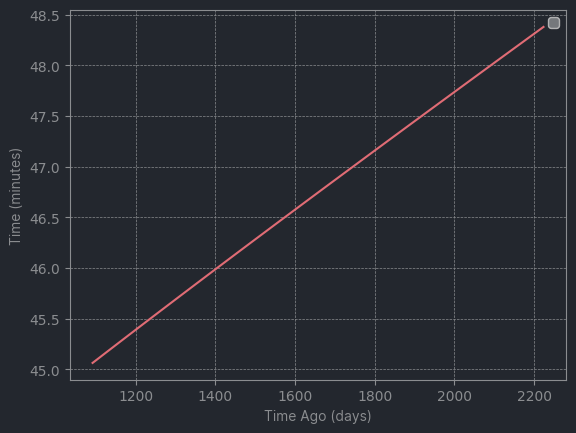

In [ ]:
handler_path = 'finder_basic/handler_8hn.pkl'

with open(handler_path, 'rb') as file:
    handler = pickle.load(file)
    
handler.plot_relationships()

The relationship between heart-rate and time-ago can have sudden step changes in gradient with LeakyReLU. Therefore, I'll tweak the selection of activation functions to improve enable better continuity of the relationship.

In [ ]:
from helpers.distance_running import ELU_NN

In [ ]:
finder_ELU = find_hn_epochs(
    model_class=ELU_NN, 
    start_hn=2, 
    stop_hn=30, 
    dataobject=data19023831
    )

finder_ELU.find(save_best=True, target_folder='finder_ELU')

with open('finder_ELU/finder_ELU.pkl', 'wb') as output:
    pickle.dump(finder_ELU, output, pickle.HIGHEST_PROTOCOL)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


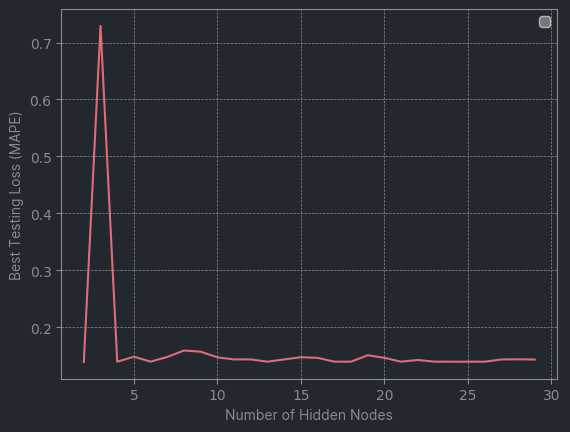

In [ ]:
with open('finder_ELU/finder_ELU.pkl', 'rb') as input:
    finder_ELU = pickle.load(input)

finder_ELU.plot_result()

Like before, there is no benefit in increasing the number of hidden nodes to above 6.

In [ ]:
handler_path = 'finder_ELU/handler_6hn.pkl'

with open(handler_path, 'rb') as file:
    base_handler = pickle.load(file)
    
print(f'Model was trained with {base_handler.total_epochs} epochs')

Model was trained with 510 epochs


In [ ]:
print(f'Best MAPE achieved on test data: {base_handler.testing_losses_mape[-1]}')

Best MAPE achieved on test data: 0.1396154761314392


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


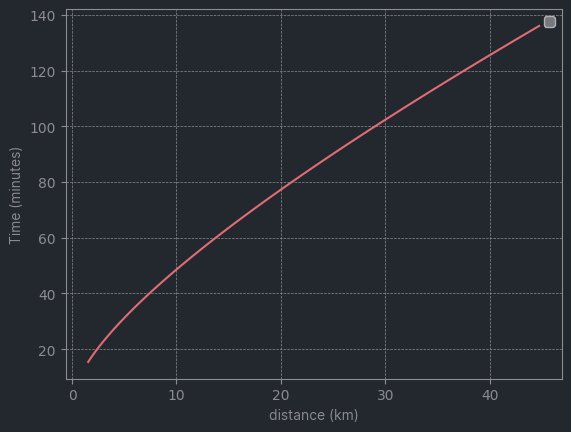

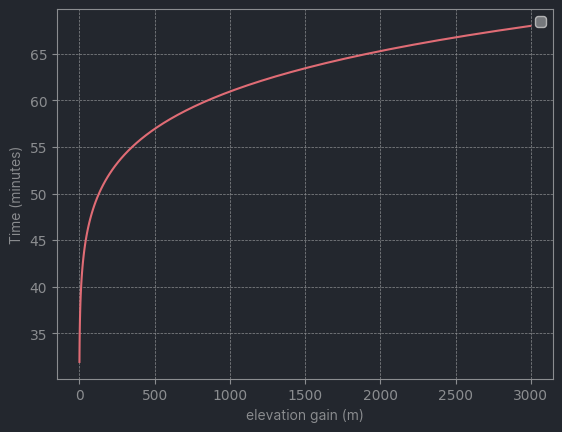

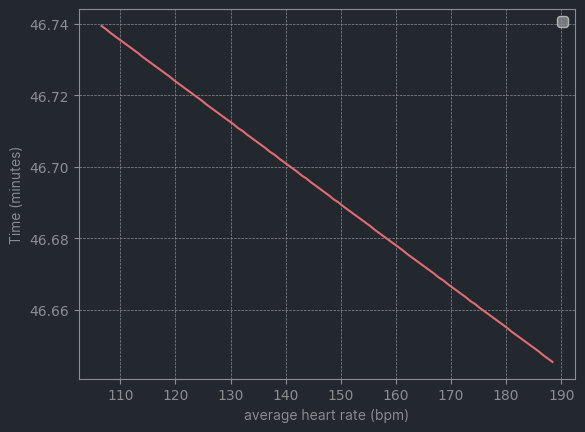

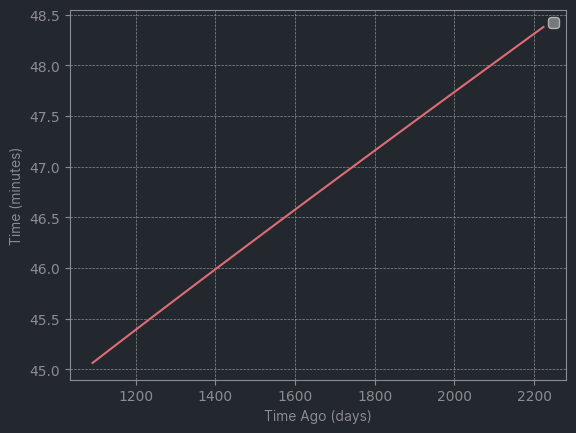

In [ ]:
base_handler.plot_relationships()

In [ ]:
base_handler.plot_training_results()

The training results show that the model was not overtrained and that the testing results have converged to a minimum. Therefore, I will use 2 hidden nodes and 128 epochs for my base models.

# **Testing out Transfer Learning**

In [ ]:
from helpers.distance_running import prepare_new_data

In [ ]:
import copy

# load the base model
handler_path = 'finder_ELU/handler_6hn.pkl'

with open(handler_path, 'rb') as file:
    base_handler = pickle.load(file)

base_model = copy.deepcopy(base_handler.model)

data_newath = athlete_data(athletes = [18223349], device = "cpu")

new_x_train_tensor, new_x_test_tensor, new_y_train_tensor, new_y_test_tensor = prepare_new_data(data19023831, data_newath)

# get the baseline error
base_mape = mape_actualtime(pred_tensor = base_model(new_x_test_tensor),
                            true_tensor = new_y_test_tensor,
                            dataobject = data19023831).detach().numpy().item()

print(f'Baseline MAPE: {base_mape}')
print(f'The new athlete has {len(data_newath.X)} data points')

Baseline MAPE: 0.1896582543849945
The new athlete has 408 data points


The baseline MAPE is already very good.

The advantage of transfer learning is the ability to fit a pretrained model to a new, very small, dataset. Therefore, I'll compare the performance when there is different number of data points available for these fine tuning methods.

In [ ]:
from time import time
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

data_fraction_list = np.linspace(0.015,1.0,15)

transfer_mape_list = []
retrained_mape_list = []
scratch_mape_list = []

mape_list = pd.DataFrame(columns = ["type", "athlete", "mape"])

epochs = 100
patience = 15
count=0
st = time()
ets = []

# load in the data

for ath in train_athletes[2:10]:

    data_newath = athlete_data(athletes = [ath], device = "cpu")

    all_x_train_tensor, all_x_test_tensor, all_y_train_tensor, all_y_test_tensor = prepare_new_data(data19023831, data_newath)

    raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(data_newath.X[INPUT_COLS].values, data_newath.y.values.reshape(-1,1), test_size = 0.1, random_state=30)

    for data_fraction in data_fraction_list:
        
        # vary the number of provided training data points
        reduced_x_train_tensor = all_x_train_tensor[:int(round((data_fraction)*len(all_x_train_tensor)))]
        reduced_y_train_tensor = all_y_train_tensor[:int(round((data_fraction)*len(all_y_train_tensor)))]

        # batch size 10% of the training set, but max size 20, min size 5
        batch_size = int(np.clip(round(0.1*len(reduced_x_train_tensor)), a_min=5, a_max=20))

        # Transfer Learning

        # create a copy to tune with transfer-learning
        transfer_model = copy.deepcopy(base_model)

        # freeze model parameters to prevent backpropagation
        for param in transfer_model.parameters():
            param.requires_grad = False

        # Reset the last layer
        # transfer_model.output = nn.Linear(
        #     transfer_model.output.in_features,
        #     transfer_model.output.out_features
        #     )
        
        # Unfreeze the last layer
        for param in transfer_model.output.parameters():
            param.requires_grad = True

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transfer_model.output.parameters(), lr=0.001)

        transfer_handler = model_handler(model = transfer_model, 
                                        dataobject = data_newath)

        transfer_handler.train(epochs = epochs,
                            batch_size = batch_size,
                            x_train_tensor = reduced_x_train_tensor,
                            y_train_tensor = reduced_y_train_tensor,
                            x_test_tensor  = new_x_test_tensor,
                            y_test_tensor  = new_y_test_tensor,
                            EarlyStopping_Patience=patience)
        transfer_mape = mape_actualtime(pred_tensor = transfer_handler.model(new_x_test_tensor),
                                        true_tensor = new_y_test_tensor,
                                        dataobject = data19023831).detach().numpy().item()
        
        # transfer_mape_list.append(transfer_mape)
        df = pd.DataFrame({
            "type": ["transfer"], 
            "athlete": [ath], 
            "data size": [int(round((data_fraction)*len(reduced_x_train_tensor)))], 
            "mape": [transfer_mape]
        })
        mape_list = pd.concat([mape_list, df])

        # Re-training all parameters (fewer epochs to prevent overfit)
        retrained_model = copy.deepcopy(base_model)

        retrained_handler = model_handler(model = retrained_model, 
                                        dataobject = data_newath)
        retrained_handler.train(epochs = epochs,
                                batch_size = batch_size,
                                x_train_tensor = reduced_x_train_tensor,
                                y_train_tensor = reduced_y_train_tensor,
                                x_test_tensor  = new_x_test_tensor,
                                y_test_tensor  = new_y_test_tensor,
                                EarlyStopping_Patience=patience)
        retrained_mape = mape_actualtime(pred_tensor = retrained_handler.model(new_x_test_tensor),
                                        true_tensor = new_y_test_tensor,
                                        dataobject = data19023831).detach().numpy().item()
        
        # retrained_mape_list.append(retrained_mape)
        df = pd.DataFrame({
            "type": ["retrain"], 
            "athlete": [ath], 
            "data size": [int(round((data_fraction)*len(reduced_x_train_tensor)))], 
            "mape": [retrained_mape]
        })
        mape_list = pd.concat([mape_list, df])

        # Create a model from scratch (randomised initial weights/biases)
        scratch_handler = model_handler(model = ELU_NN(6),
                                        dataobject=data_newath)

        x_raw = raw_x_train.copy()
        x_yjpt = PowerTransformer(method='yeo-johnson')
        x_transformed = x_yjpt.fit_transform(x_raw)
        x_transformed[:,2] = x_raw[:,2]
        x_scaler = MinMaxScaler(feature_range=(0,1))
        x_scaled_train = x_scaler.fit_transform(x_transformed)

        y_raw = raw_y_train.copy()
        y_yjpt = PowerTransformer(method='yeo-johnson')
        y_transformed = y_yjpt.fit_transform(y_raw)
        y_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaled_train = y_scaler.fit_transform(y_transformed)

        x_scaled_test = x_scaler.transform(x_yjpt.transform(raw_x_test))
        y_scaled_test = y_scaler.transform(y_yjpt.transform(raw_y_test))

        # x_raw = raw_x_train.copy()
        # x_scaler = MinMaxScaler(feature_range=(0,1))
        # x_scaled_train = x_scaler.fit_transform(x_raw)

        # y_raw = raw_y_train.copy()
        # y_scaler = MinMaxScaler(feature_range=(0,1))
        # y_scaled_train = y_scaler.fit_transform(y_raw)

        # x_scaled_test = x_scaler.transform(raw_x_test)
        # y_scaled_test = y_scaler.transform(raw_y_test)

        x_train_tensor = torch.tensor(x_scaled_train).float().to('cpu')
        x_test_tensor = torch.tensor(x_scaled_test).float().to('cpu')
        y_train_tensor = torch.tensor(y_scaled_train).float().to('cpu')
        y_test_tensor = torch.tensor(y_scaled_test).float().to('cpu')

        reduced_x_train_tensor = x_train_tensor[:int(round((data_fraction)*len(x_train_tensor)))]
        reduced_y_train_tensor = y_train_tensor[:int(round((data_fraction)*len(y_train_tensor)))]

        scratch_handler.train(epochs = epochs,
                            batch_size = batch_size,
                            x_train_tensor = reduced_x_train_tensor,
                            y_train_tensor = reduced_y_train_tensor,
                            x_test_tensor  = x_test_tensor,
                            y_test_tensor  = y_test_tensor,
                            EarlyStopping_Patience=patience)

        pred_seconds = scratch_handler.model(x_test_tensor).detach().numpy()

        pred_seconds = y_yjpt.inverse_transform(y_scaler.inverse_transform(pred_seconds)).flatten()

        # pred_seconds = y_scaler.inverse_transform(pred_seconds).flatten()

        scratch_mape = sum(abs((pred_seconds-raw_y_test.flatten())/(raw_y_test.flatten())))/len(raw_y_test)

        # scratch_mape_list.append(scratch_mape)
        df = pd.DataFrame({
            "type": ["scratch"], 
            "athlete": [ath], 
            "data size": [int(round((data_fraction)*len(reduced_x_train_tensor)))], 
            "mape": [scratch_mape]
        })
        mape_list = pd.concat([mape_list, df])
        
        clear_output(wait=True)
        count += 1
        et = time()-st
        ets.append(et)
        et = np.mean(ets[-3:])
        pc = count/(len(data_fraction_list)*8)
        etr = et/pc * (1-pc)
        print(f'{pc*100:.1f}% complete | Estimated time remaining = {etr/60:.2f} minutes')

100.0% complete | Estimated time remaining = 0.00 minutes


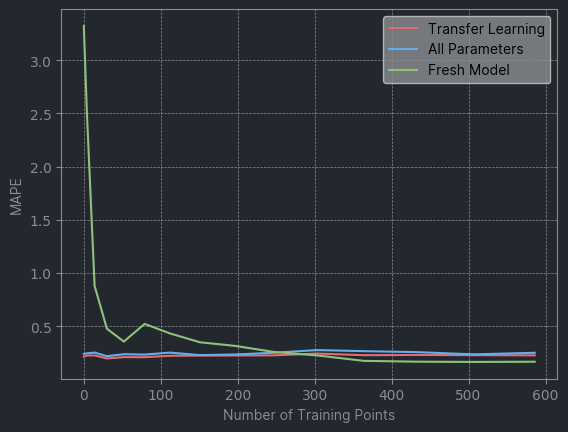

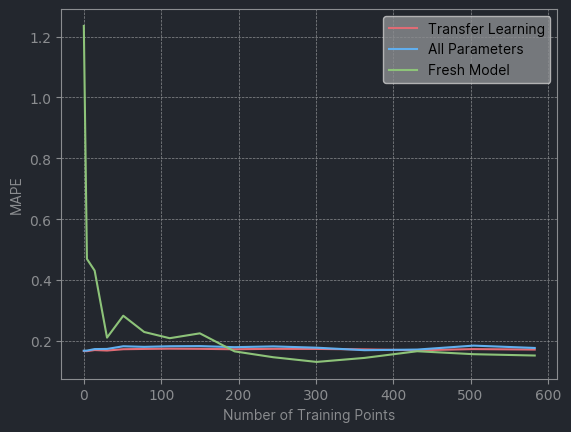

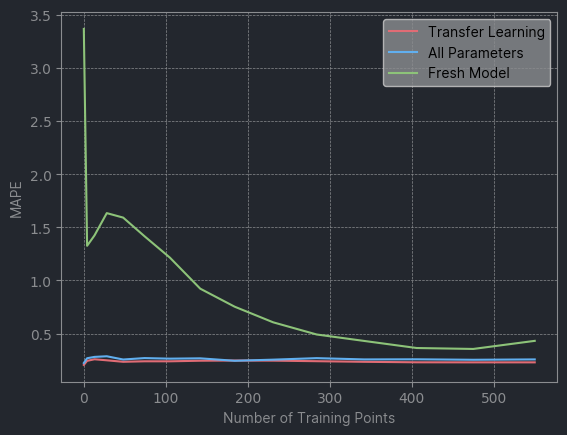

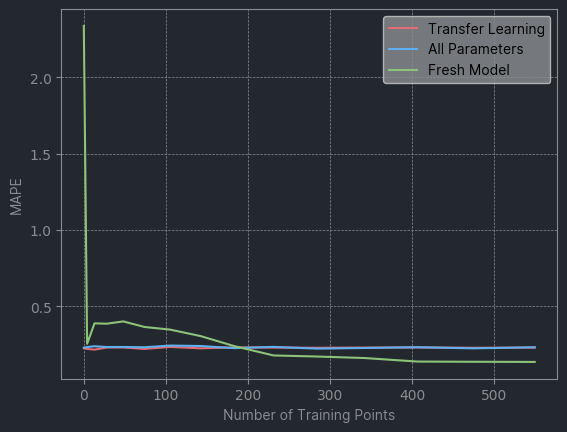

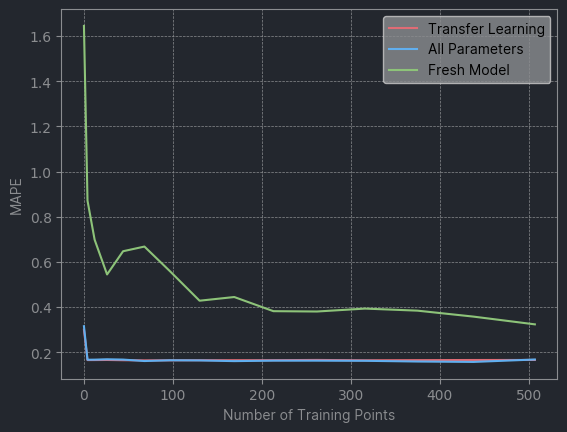

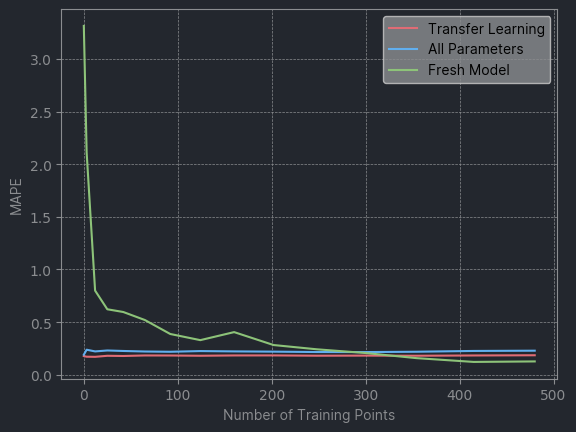

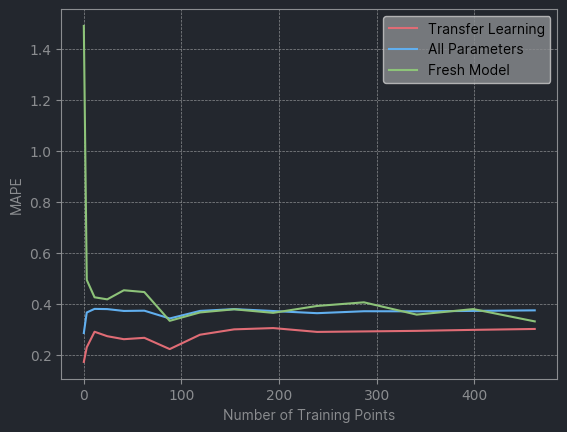

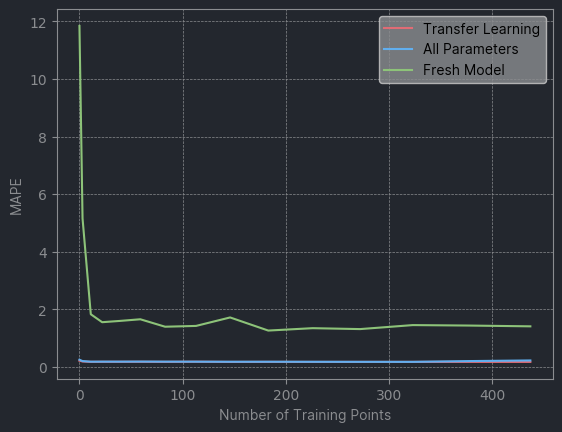

In [ ]:
from helpers.my_plotting import my_xyline

for ath in mape_list['athlete'].unique():

    filtered_mape_list = mape_list[mape_list['athlete'] == ath]

    transfer_mape_list = filtered_mape_list[filtered_mape_list['type'] == 'transfer'].sort_values('data size').groupby('data size')['mape'].mean().values

    retrained_mape_list = filtered_mape_list[filtered_mape_list['type'] == 'retrain'].sort_values('data size').groupby('data size')['mape'].mean().values

    scratch_mape_list = filtered_mape_list[filtered_mape_list['type'] == 'scratch'].sort_values('data size').groupby('data size')['mape'].mean().values

    data_sizes = filtered_mape_list.sort_values('data size')['data size'].unique()

    my_xyline(x1 = data_sizes,
            y1 = transfer_mape_list,
            y1_label='Transfer Learning',
            x2 = data_sizes,
            y2 = retrained_mape_list,
            y2_label='All Parameters',
            x3 = data_sizes,
            y3 = scratch_mape_list,
            y3_label='Fresh Model',
            y_label='MAPE',
            x_label='Number of Training Points')

The general trend is that all-parameter fine-tuning and transfer learning both performing significantly better than creating a completely new model when there are fewer than several hundred new samples.

In most cases, fine tuning a base model achieved better loss even when there were several hundred new samples.

Transfer learning consistently performed slightly better than all-parameter fine-tuning.

# **Creating Base Models**

In [ ]:
print(f'Number of athletes to train with: {len(train_athletes)}')
print(train_athletes)

Number of athletes to train with: 46
[19023831, 17639804, 23729907, 3573750, 10825360, 6367873, 20653961, 16378210, 2081128, 10446972, 18736169, 22835898, 5035018, 6215611, 7947798, 5688059, 11348733, 18223349, 5421161, 5151970, 3460571, 19741163, 5861500, 12021072, 25191153, 15515123, 11088529, 11284478, 3539760, 22843389, 14588097, 20136629, 2913078, 16021442, 22891135, 34669133, 1776170, 26367918, 21299972, 12701438, 14019837, 12740383, 34460713, 18042525, 22353493, 12642956]


In [ ]:
import os

# move the first base model in to the folder

handler_path = 'finder_ELU/handler_6hn.pkl'

try:
    os.mkdir('base_models_complete')
except FileExistsError:
    pass

with open(handler_path, 'rb') as input:
    base_handler = pickle.load(input)

with open('base_models_complete/handler001.pkl', 'wb') as output:
    pickle.dump(base_handler, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
# create a JSON to keep track of which athletes have been included in which model/handler
import json 

handler_tracker = {
    'athletes_completed': [],
    'handler001.pkl': {
        'athlete': '[19023831]',
    }
}

with open('base_models_complete/handler_tracker_complete.json', 'w') as output:
    json.dump(handler_tracker, output)

In [ ]:
from helpers.distance_running import update_handler_tracker

In [ ]:
update_handler_tracker('complete')

In [ ]:
# create a base model for each athlete in train_athletes

num = 0

st= time()
for ath in train_athletes[num:]:

    new_dataobject = athlete_data(athletes = [ath], device = "cpu")

    # create a new base model
    new_handler = model_handler(
        model = LeakyReLU_NN(6), 
        dataobject = new_dataobject
        ) 
    
    new_handler.train(
        epochs = 512, 
        batch_size = 20,
        save_best = True,
        save_path = f'base_models_LeakyReLU/handler{str(num).zfill(3)}.pkl',
        EarlyStopping_Patience=25,
        factor_duplications=0.1
    )

    num+=1

    handler_tracker = update_handler_tracker('LeakyReLU')

    clear_output(wait=True)
    et = time()-st
    pc = num/(len(train_athletes))
    etr = et/pc * (1-pc)
    print(f'{pc*100:.1f}% complete | Estimated time remaining = {etr/60:.2f} minutes')

In [ ]:
# create a base model for each athlete in train_athletes

num = 2

for ath in train_athletes[num:]:

    new_dataobject = athlete_data(athletes = [ath], device = "cpu")

    # create a new base model
    new_handler = model_handler(
        model = ELU_NN(6), 
        dataobject = new_dataobject
        ) 
    
    new_handler.train(
        epochs = 512, 
        batch_size = 20,
        save_best = True,
        save_path = f'base_models_complete/handler{str(num).zfill(3)}.pkl',
        EarlyStopping_Patience=25,
        factor_duplications=0.1
    )

    num+=1

    handler_tracker = update_handler_tracker('complete')

In [ ]:
# continue training

target_folder = 'base_models_complete'

for filename in os.listdir(target_folder):

    if filename.endswith('.pkl'):
        with open(f'{target_folder}/{filename}', 'rb') as input:
            temp_handler = pickle.load(input)

        clear_output(wait=True)
        print(filename)

        temp_handler.train(
            epochs = 256, # 128 was found as an optimal number of epochs
            batch_size = 20,
            save_best = True,
            save_path = f'{target_folder}/{filename}'
        )

        handler_tracker = update_handler_tracker('complete')

In [ ]:
import shutil

for ath in train_athletes[1:]:

    bad_fit = []
    new_dataobject = athlete_data(athletes = [ath], device = "cpu")

    # test on all pre-trained base models
    for file in os.listdir('base_models_ft'):

        # load the base model
        if file.endswith('.pkl'):
            with open(f'base_models_ft/{file}', 'rb') as input:
                base_handler = pickle.load(input)

            # create a new data object for the athlete
            base_dataobject = base_handler.dataobject

            # scale the new data with the base scalers, and shift the timeago variable
            reduced_x_train_tensor, new_x_test_tensor, reduced_y_train_tensor, new_y_test_tensor = prepare_new_data(base_dataobject, new_dataobject)

            # test the MAPE on the test data
            base_mape = mape_actualtime(pred_tensor = base_handler.model(new_x_test_tensor),
                                        true_tensor = new_y_test_tensor,
                                        dataobject = data19023831).detach().numpy().item()
            
            bad_fit.append(base_mape > 1.05 * base_handler.testing_losses_mape[-1])

            if base_mape < 1.05 * base_handler.testing_losses_mape[-1]:

                # deprecate the base model
                source = f"base_models_ft/{file}"
                destination = f"base_models_ft/deprecated/{file}"
                shutil.move(source, destination)

                # train a new model with both athletes' datapoints
                athletes = base_dataobject.athlete + [ath]
                add_dataobject = athlete_data(athletes = athletes, device = "cpu")
                new_handler = model_handler(model = ELU_NN(2), 
                                            dataobject = add_dataobject)
                
            else:
                new_handler = model_handler(
                    model = ELU_NN(2), # 2 was found as an optimal number of hidden nodes
                    dataobject = new_dataobject
                    ) 

            # get the latest number of base model and +1
            num = str(int(file[-7:-4])+1).zfill(3)

            new_handler.train(
                epochs = 128, # 128 was found as an optimal number of epochs
                batch_size = 20, 
                save_best = True,
                save_path = f'base_models_ft/handler{num}.pkl'
            )

    handler_tracker = update_handler_tracker(target_json='handler_tracker_ft.json', target_folder='base_models_ft')


In [ ]:
update_handler_tracker('complete');
update_handler_tracker('ft');

In [ ]:
temp_dataobject = athlete_data(athletes=[test_athletes[0]], device='cpu')

user_df = temp_dataobject.X

user_df["elapsed time (s)"] = temp_dataobject.y

user_df

In [ ]:
from helpers.distance_running import read_strava_csv, time_before_race, prepare_user_data

In [ ]:
from helpers.distance_running import get_best_model, user_finetune

In [ ]:
# race_info = pd.DataFrame({
#     'distance (m)': [(5.1)*1e3],
#     'elevation gain (m)': [0.0],	
#     'average heart rate (bpm)': [175],	
#     'timestamp': ['2024-05-20']
# })

race_info = pd.DataFrame({
    'distance (m)': [5000],
    'elevation gain (m)': [0.0],	
    'average heart rate (bpm)': [175],	
    'timestamp': ['2024-05-20']
})

race_info = pd.DataFrame({
    'distance (m)': [5000],
    'elevation gain (m)': [0.0],	
    'average heart rate (bpm)': [186],	
    'timestamp': ['2023-06-24']
})

race_info = pd.DataFrame({
    'distance (m)': [10000],
    'elevation gain (m)': [0.0],	
    'average heart rate (bpm)': [175],	
    'timestamp': ['2023-07-22']
})

race_info['distance (m)'] = race_info['distance (m)']*1.02

In [ ]:
import pandas as pd
from helpers.distance_running import model_handler, athlete_data, user_finetune, LeakyReLU_NN, read_strava_csv
# from helpers.distance_running import get_best_model
from IPython.display import clear_output

In [143]:
import os
import pickle
from helpers.distance_running import get_best_model, time_before_race
import pandas as pd
import numpy as np
from IPython.display import clear_output
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import os
import shutil
from time import time, sleep
import pickle
import copy
import json
from helpers.my_plotting import my_interactable_xyline, my_traintestpredictions, my_xyline

def prepare_user_data(base_dataobject, user_df, race_info):
    '''
    Shifts the timeago of the user data so that the user's race has the same timeago as the newest run of the base_dataobject.

    The fitted transforms and scalers of the base_dataobject will be used to transform and scale the user data
    '''

    # create the time ago column using the race date as the datum
    user_df = time_before_race(user_df, race_info)

    # assign a time ago value to the race info row (time ago is 0)
    race_info_ta = race_info.copy()
    race_info_ta['time ago (s)'] = 0.0

    delta_timeago = 0.0 - base_dataobject.X["time ago (s)"].min()

    x_offset = user_df[['distance (m)','elevation gain (m)','average heart rate (bpm)','time ago (s)']]

    x_offset = pd.concat([x_offset, race_info_ta[['distance (m)','elevation gain (m)','average heart rate (bpm)', 'time ago (s)']]])

    # offset the timeago
    x_offset.loc[:, "time ago (s)"] = x_offset["time ago (s)"] - delta_timeago

    # transform the x data
    x_transformed = pd.DataFrame()
    x_transformed["distance"] = base_dataobject.yjpt_distance.transform(x_offset["distance (m)"].values.reshape(-1,1)).reshape(-1)
    x_transformed["elevation"] = base_dataobject.yjpt_elevation.transform(x_offset["elevation gain (m)"].values.reshape(-1,1)).reshape(-1)
    x_transformed["hr"] = x_offset["average heart rate (bpm)"].values
    x_transformed["timeago"] = base_dataobject.yjpt_timeago.transform(x_offset["time ago (s)"].values.reshape(-1,1)).reshape(-1)

    # scale the x data
    x_scaled = base_dataobject.x_scaler.transform(x_transformed) # np.ndarray

    # transform and scale the y data
    y_transformed = base_dataobject.yjpt_time.transform(user_df["elapsed time (s)"].values.reshape(-1,1))
    user_y_scaled = base_dataobject.y_scaler.transform(y_transformed) # np.ndarray

    # extract the race row
    x_race_tensor = torch.tensor(x_scaled[-1,:].reshape(1,-1)).float().to(base_dataobject.device)
    y_race_tensor = torch.tensor(user_y_scaled[-1,:].reshape(1,-1)).float().to(base_dataobject.device)

    # drop the race row
    x_scaled = x_scaled[:-1,:]

    # split the data
    user_x_train, user_x_test, user_y_train, user_y_test = train_test_split(x_scaled, user_y_scaled, test_size = 0.1, random_state=30)

    # convert to tensors
    x_train_tensor = torch.tensor(user_x_train).float().to(base_dataobject.device)
    x_test_tensor = torch.tensor(user_x_test).float().to(base_dataobject.device)
    y_train_tensor = torch.tensor(user_y_train).float().to(base_dataobject.device)
    y_test_tensor = torch.tensor(user_y_test).float().to(base_dataobject.device)

    return x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor

def get_best_model_19(user_df, race_info, model_folder = 'base_models_LeakyReLU'):
    '''
    Returns 
    1. The model handler with the best MAPE loss on the test dataset.
    2. The train and test tensors, transformed and scaled by the best model handler.
    3. MAPE results across all models.
    '''

    result = pd.DataFrame({
        "handler": [],
        "mape": [],
        "x_train_tensor": [],
        "x_test_tensor": [],
        "y_train_tensor": [],
        "y_test_tensor": [],
        "x_race_tensor": [],
        "y_race_tensor": []
    })

    for filename in os.listdir(model_folder):

        if filename.endswith('.pkl'):
            with open(f'{model_folder}/{filename}', 'rb') as input:
                base_handler = pickle.load(input)

        x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor = prepare_user_data(base_handler.dataobject, user_df, race_info)


        # test the MAPE on the test data
        mape = mape_actualtime(pred_tensor = base_handler.model(x_test_tensor),
                               true_tensor = y_test_tensor,
                               dataobject = data19023831).detach().numpy().item()
        # mape = mape_actualtime(pred_tensor = base_handler.model(x_test_tensor),
                            #    true_tensor = y_test_tensor,
                            #    dataobject = base_handler.dataobject).detach().numpy().item()

        result = pd.concat([result,pd.DataFrame({
            "handler": [base_handler], 
            "mape": [mape],
            "x_train_tensor": [x_train_tensor],
            "x_test_tensor": [x_test_tensor],
            "y_train_tensor": [y_train_tensor],
            "y_test_tensor": [y_test_tensor],
            "x_race_tensor": [x_race_tensor],
            "y_race_tensor": [y_race_tensor]      
            })])

    best_idx = result["mape"].argmin()
    handler = result.iloc[best_idx]["handler"]
    x_train_tensor = result.iloc[best_idx]["x_train_tensor"]
    x_test_tensor = result.iloc[best_idx]["x_test_tensor"]
    y_train_tensor = result.iloc[best_idx]["y_train_tensor"]
    y_test_tensor = result.iloc[best_idx]["y_test_tensor"]
    x_race_tensor = result.iloc[best_idx]["x_race_tensor"]
    y_race_tensor = result.iloc[best_idx]["y_race_tensor"]

    print(result.iloc[best_idx]["mape"])

    mape = mape_actualtime(pred_tensor = handler.model(x_test_tensor),
                           true_tensor = y_test_tensor,
                           dataobject = handler.dataobject).detach().numpy().item()
    
    print(mape)

    return handler, x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor, result

def get_best_model(user_df, race_info, model_folder = 'base_models_LeakyReLU'):
    '''
    Returns 
    1. The model handler with the best MAPE loss on the test dataset.
    2. The train and test tensors, transformed and scaled by the best model handler.
    3. MAPE results across all models.
    '''

    result = pd.DataFrame({
        "handler": [],
        "mape": [],
        "x_train_tensor": [],
        "x_test_tensor": [],
        "y_train_tensor": [],
        "y_test_tensor": [],
        "x_race_tensor": [],
        "y_race_tensor": []
    })

    for filename in os.listdir(model_folder):

        if filename.endswith('.pkl'):
            with open(f'{model_folder}/{filename}', 'rb') as input:
                base_handler = pickle.load(input)

        x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor = prepare_user_data(base_handler.dataobject, user_df, race_info)


        # test the MAPE on the test data
        # mape = mape_actualtime(pred_tensor = base_handler.model(x_test_tensor),
        #                        true_tensor = y_test_tensor,
        #                        dataobject = data19023831).detach().numpy().item()
        mape = mape_actualtime(pred_tensor = base_handler.model(x_test_tensor),
                               true_tensor = y_test_tensor,
                               dataobject = base_handler.dataobject).detach().numpy().item()

        result = pd.concat([result,pd.DataFrame({
            "handler": [base_handler], 
            "mape": [mape],
            "x_train_tensor": [x_train_tensor],
            "x_test_tensor": [x_test_tensor],
            "y_train_tensor": [y_train_tensor],
            "y_test_tensor": [y_test_tensor],
            "x_race_tensor": [x_race_tensor],
            "y_race_tensor": [y_race_tensor]      
            })])

    best_idx = result["mape"].argmin()
    handler = result.iloc[best_idx]["handler"]
    x_train_tensor = result.iloc[best_idx]["x_train_tensor"]
    x_test_tensor = result.iloc[best_idx]["x_test_tensor"]
    y_train_tensor = result.iloc[best_idx]["y_train_tensor"]
    y_test_tensor = result.iloc[best_idx]["y_test_tensor"]
    x_race_tensor = result.iloc[best_idx]["x_race_tensor"]
    y_race_tensor = result.iloc[best_idx]["y_race_tensor"]

    print(result.iloc[best_idx]["mape"])

    return handler, x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor, result

In [10]:
# race_info = pd.DataFrame({
#     'distance (m)': [10000],
#     'elevation gain (m)': [0.0],	
#     'average heart rate (bpm)': [175],	
#     'timestamp': ['2023-07-23']
# })

In [137]:
user_df = read_strava_csv()

user_df = user_df[user_df["timestamp"] < race_info['timestamp'][0]]

In [142]:
result = get_best_model(user_df, race_info, model_folder = 'base_models_LeakyReLU')

result

0.25886934995651245


,handler,mape,x_train_tensor,x_test_tensor,y_train_tensor,y_test_tensor,x_race_tensor,y_race_tensor
0,<helpers.distance_running.model_handler object...,0.268488,"[[tensor(0.5827), tensor(0.3593), tensor(0.555...","[[tensor(0.4032), tensor(0.3503), tensor(0.671...","[[tensor(0.5761)], [tensor(-0.0194)], [tensor(...","[[tensor(0.3656)], [tensor(0.4233)], [tensor(-...","[[tensor(0.5256), tensor(0.), tensor(0.8362), ...",[[tensor(0.6037)]]
0,<helpers.distance_running.model_handler object...,0.407385,"[[tensor(0.4546), tensor(0.4371), tensor(0.538...","[[tensor(0.3109), tensor(0.4275), tensor(0.668...","[[tensor(0.5411)], [tensor(-0.0110)], [tensor(...","[[tensor(0.3607)], [tensor(0.4116)], [tensor(-...","[[tensor(0.4084), tensor(0.), tensor(0.8542), ...",[[tensor(0.5636)]]
0,<helpers.distance_running.model_handler object...,0.258869,"[[tensor(0.5467), tensor(0.4117), tensor(0.541...","[[tensor(0.3817), tensor(0.4022), tensor(0.699...","[[tensor(0.5960)], [tensor(-0.0238)], [tensor(...","[[tensor(0.4013)], [tensor(0.4570)], [tensor(-...","[[tensor(0.4943), tensor(0.), tensor(0.9236), ...",[[tensor(0.6198)]]
0,<helpers.distance_running.model_handler object...,0.416448,"[[tensor(0.5867), tensor(0.1701), tensor(0.715...","[[tensor(0.4068), tensor(0.1634), tensor(0.816...","[[tensor(0.5885)], [tensor(-0.0469)], [tensor(...","[[tensor(0.3471)], [tensor(0.4114)], [tensor(-...","[[tensor(0.5295), tensor(0.), tensor(0.9614), ...",[[tensor(0.6215)]]
0,<helpers.distance_running.model_handler object...,0.431435,"[[tensor(0.4376), tensor(0.2347), tensor(0.280...","[[tensor(0.2927), tensor(0.2278), tensor(0.411...","[[tensor(0.5182)], [tensor(-0.1121)], [tensor(...","[[tensor(0.3169)], [tensor(0.3742)], [tensor(-...","[[tensor(0.3909), tensor(0.), tensor(0.5992), ...",[[tensor(0.5430)]]
0,<helpers.distance_running.model_handler object...,0.339384,"[[tensor(0.6364), tensor(0.2816), tensor(0.481...","[[tensor(0.3965), tensor(0.2730), tensor(0.623...","[[tensor(0.5962)], [tensor(0.0127)], [tensor(0...","[[tensor(0.3475)], [tensor(0.4104)], [tensor(-...","[[tensor(0.5550), tensor(0.), tensor(0.8271), ...",[[tensor(0.6330)]]
0,<helpers.distance_running.model_handler object...,0.447558,"[[tensor(0.4417), tensor(0.3622), tensor(0.765...","[[tensor(0.2967), tensor(0.3533), tensor(0.868...","[[tensor(0.5709)], [tensor(0.0127)], [tensor(0...","[[tensor(0.3836)], [tensor(0.4359)], [tensor(-...","[[tensor(0.3946), tensor(0.), tensor(1.0141), ...",[[tensor(0.5947)]]
0,<helpers.distance_running.model_handler object...,0.449582,"[[tensor(0.4914), tensor(0.2774), tensor(0.560...","[[tensor(0.3074), tensor(0.2694), tensor(0.729...","[[tensor(0.5564)], [tensor(-0.0905)], [tensor(...","[[tensor(0.3327)], [tensor(0.3945)], [tensor(-...","[[tensor(0.4303), tensor(0.), tensor(0.9698), ...",[[tensor(0.5853)]]
0,<helpers.distance_running.model_handler object...,0.772956,"[[tensor(0.5482), tensor(0.2033), tensor(0.476...","[[tensor(0.2719), tensor(0.1964), tensor(0.602...","[[tensor(0.6036)], [tensor(-0.1760)], [tensor(...","[[tensor(0.3092)], [tensor(0.3877)], [tensor(-...","[[tensor(0.4504), tensor(0.), tensor(0.7819), ...",[[tensor(0.6437)]]
0,<helpers.distance_running.model_handler object...,0.471851,"[[tensor(0.4990), tensor(0.3249), tensor(0.628...","[[tensor(0.3278), tensor(0.3145), tensor(0.801...","[[tensor(0.5939)], [tensor(-0.0215)], [tensor(...","[[tensor(0.3869)], [tensor(0.4447)], [tensor(-...","[[tensor(0.4431), tensor(-0.1091), tensor(1.04...",[[tensor(0.6203)]]


In [144]:
base_handler, x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor, result  = get_best_model(user_df, race_info, model_folder = 'base_models_LeakyReLU')

0.25886934995651245


In [146]:
base_handler.predict(x_race_tensor, scaled=True)

(6.696854654947916,
 array([[ -11.257753,   -4.824151,  175.      , -136.9156  ]],
       dtype=float32))

In [139]:
base_handler, x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor, result  = get_best_model_19(user_df, race_info, model_folder = 'base_models_LeakyReLU')

0.20060023665428162
0.6410028338432312


In [148]:
user_df = read_strava_csv()

user_df = user_df[user_df["timestamp"] < race_info['timestamp'][0]]

base_handler, x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor, result  = get_best_model(user_df, race_info, model_folder = 'base_models_LeakyReLU')

ft_handler = user_finetune(base_handler, 
                           x_train_tensor, 
                           x_test_tensor, 
                           y_train_tensor, 
                           y_test_tensor,
                           epochs = 1028,
                           batch_size=1)

clear_output()
confidence = ft_handler.testing_losses_mape[-1]
print(f'Confidence: {(1-confidence)*100:.2f}%')

prediction = ft_handler.predict(x_race_tensor, scaled = True)

time = prediction[0]

print(time)
print(f'Upper: {time*(1+confidence)}, Lower: {time*(1-confidence)}')

Confidence: 79.86%
22.49906005859375
Upper: 27.02974910815192, Lower: 17.96837100903558


In [149]:
prediction

(22.49906005859375,
 array([[ 1.0199997e+04, -3.5762787e-07,  1.7500000e+02,  9.4464040e+07]],
       dtype=float32))

In [119]:
base_handler.dataobject.athlete

[18042525]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


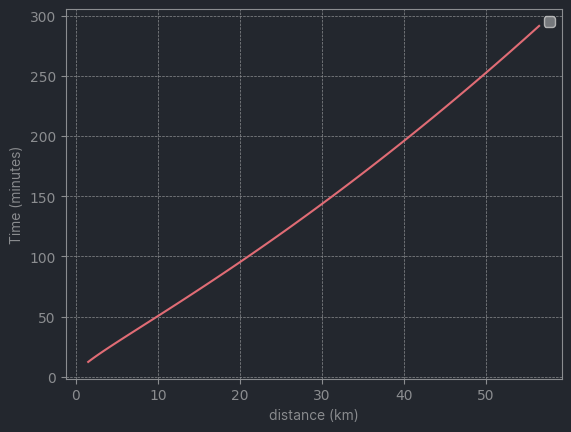

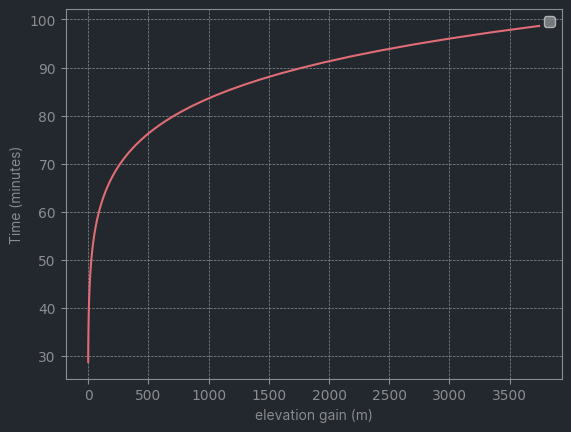

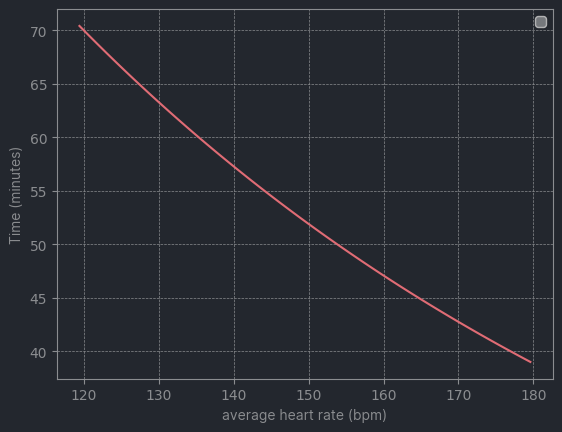

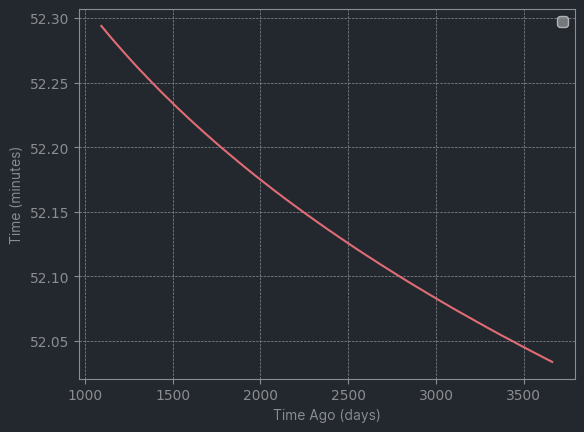

In [14]:
ft_handler.plot_relationships()

In [12]:
ft_handler.plot_training_results()

In [16]:
from helpers.my_plotting import my_traintestpredictions
from helpers.distance_running import INPUT_COLS

(-0.8590164303779602, 1.08852459192276, -0.05, 1.05)

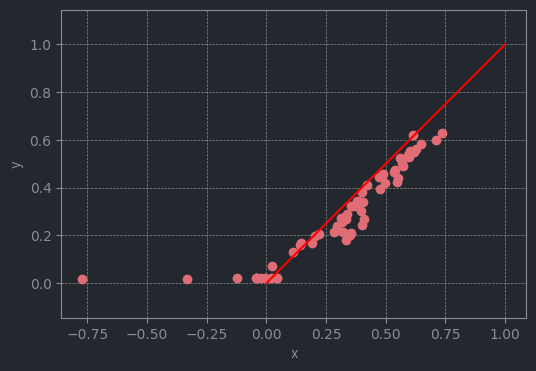

In [7]:
from helpers.my_plotting import my_xyscatter
import numpy as np
x = y_train_tensor.detach().numpy().flatten()
y = ft_handler.model(x_train_tensor.unsqueeze(1)).detach().numpy().flatten()
fig, ax = my_xyscatter(x, y)
ax.plot(np.linspace(0,1,2),np.linspace(0,1,2), color='red')
ax.axis('equal')

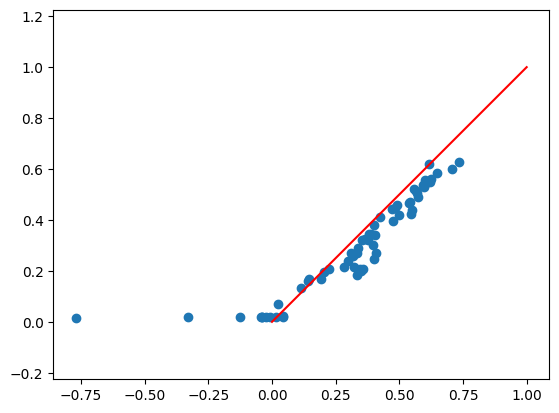

In [33]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(y_train_tensor,ft_handler.model(x_train_tensor.unsqueeze(1)).detach().numpy())
plt.plot(np.linspace(0,1,2),np.linspace(0,1,2), color='red')
plt.axis('equal')
plt.show()

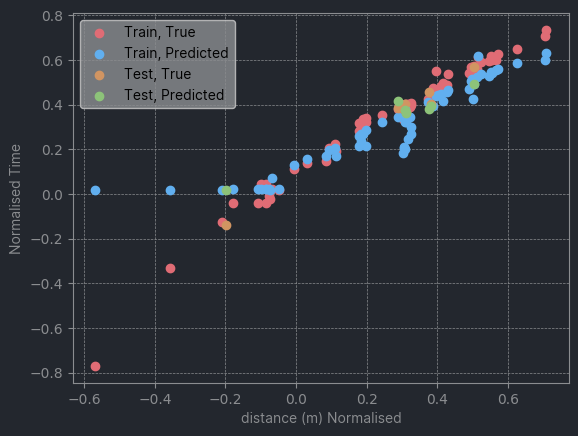

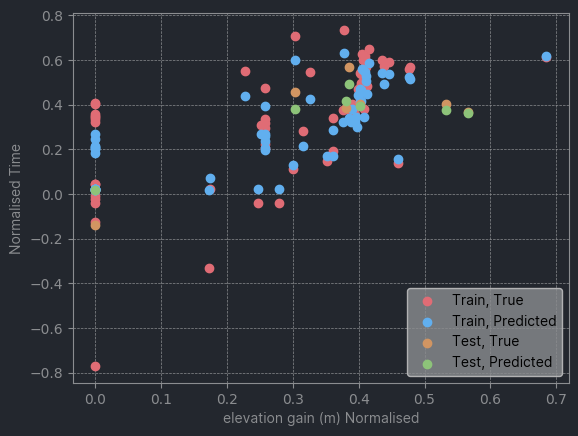

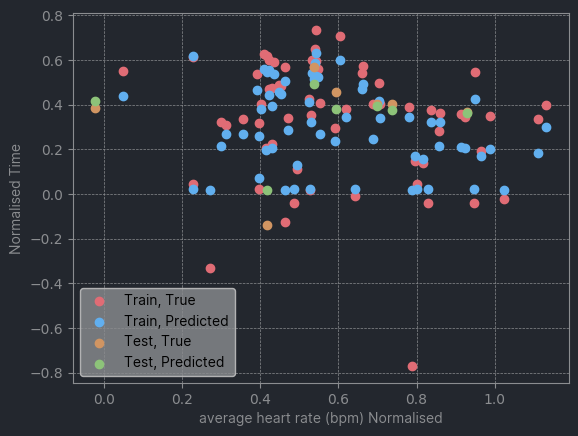

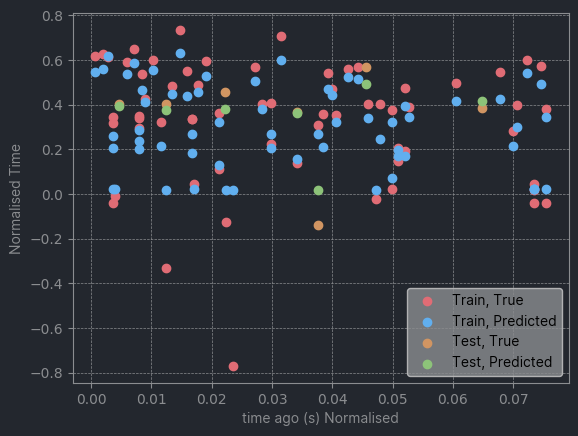

In [17]:
for i in range(4):
    my_traintestpredictions(x_train=x_train_tensor[:,i],
                            y_train=y_train_tensor,
                            y_train_pred=ft_handler.model(x_train_tensor.unsqueeze(1)).detach().numpy(),
                            x_test=x_test_tensor[:,i],
                            y_test=y_test_tensor,
                            y_test_pred=ft_handler.model(x_test_tensor.unsqueeze(1)).detach().numpy(),
                            x_name=INPUT_COLS[i]+' Normalised',
                            y_name='Normalised Time')

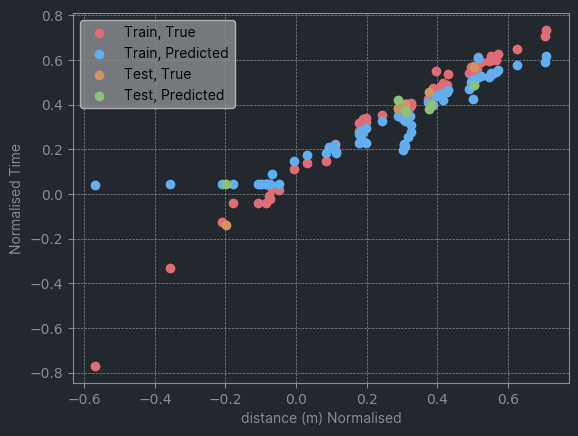

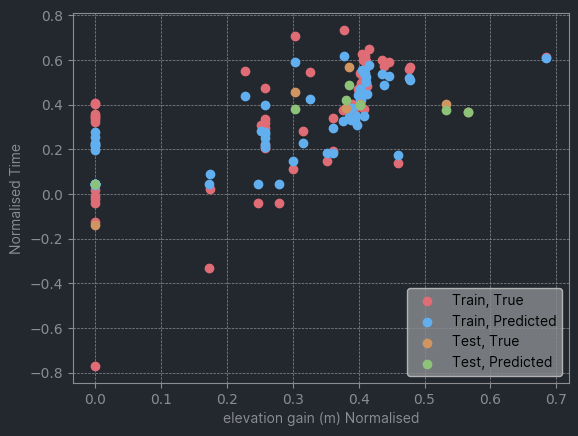

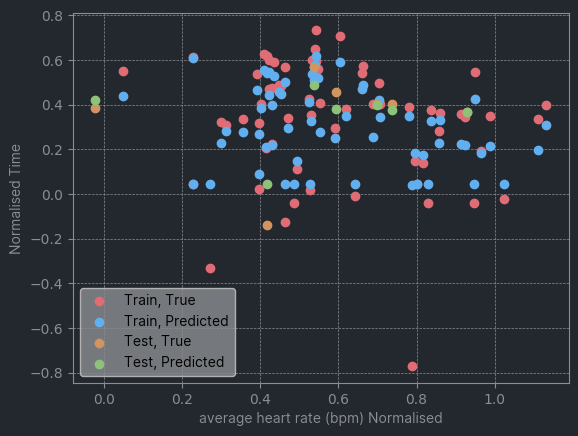

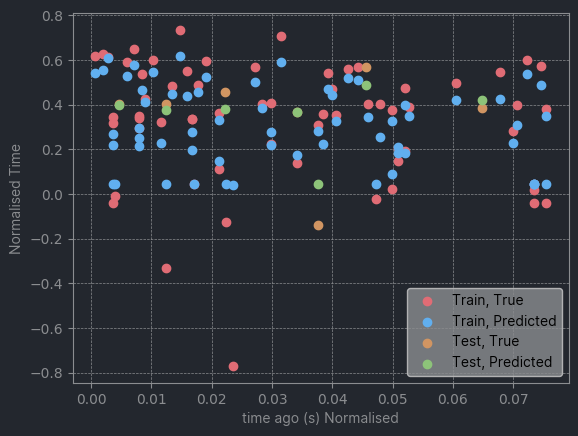

In [21]:
for i in range(4):
    my_traintestpredictions(x_train=x_train_tensor[:,i],
                            y_train=y_train_tensor,
                            y_train_pred=base_handler.model(x_train_tensor.unsqueeze(1)).detach().numpy(),
                            x_test=x_test_tensor[:,i],
                            y_test=y_test_tensor,
                            y_test_pred=base_handler.model(x_test_tensor.unsqueeze(1)).detach().numpy(),
                            x_name=INPUT_COLS[i]+' Normalised',
                            y_name='Normalised Time')

In [ ]:
# race_info = pd.DataFrame({
#     'distance (m)': [10000],
#     'elevation gain (m)': [0.0],	
#     'average heart rate (bpm)': [175],	
#     'timestamp': ['2023-07-22']
# })

user_df = read_strava_csv()
user_df = user_df[user_df["timestamp"] < race_info['timestamp'][0]]

user_df = time_before_race(user_df, race_info)

user_df["pace (min/km)"] = (user_df["elapsed time (s)"]/60)/(user_df["distance (m)"]/1000)
user_df['athlete'] = np.full(shape=(len(user_df)), fill_value='Aidan')

data = pd.concat([original_data, user_df])

aidan_data = athlete_data(athletes=["Aidan"], device = "cpu")

aidan_handler = model_handler(model = LeakyReLU_NN(25), dataobject = aidan_data)

aidan_handler.train(
    epochs = 512,
    batch_size = 1,
    EarlyStopping_Patience=100,
    factor_duplications=0.1,
    # learning_rate=0.0005
)

In [ ]:
aidan_handler.plot_training_results()

In [ ]:
user_df = read_strava_csv()
user_df = user_df[user_df["timestamp"] < race_info['timestamp'][0]]
x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor = prepare_user_data(aidan_data, user_df, race_info)

predicted_time, unscaled_data = aidan_handler.predict(x_race_tensor, scaled=True)

confidence = aidan_handler.testing_losses_mape[-1]
print(f'Confidence: {(1-confidence)*100:.2f}%')

print(predicted_time)
print(f'Upper: {predicted_time*(1+confidence)}, Lower: {predicted_time*(1-confidence)}')

In [ ]:
aidan_handler.plot_traintestpredictions()

In [ ]:
aidan_handler.plot_relationships()

In [ ]:
aidan_handler.plot_training_results()

In [ ]:
with open('finder_ELU/handler_6hn.pkl', 'rb') as input:
    elu_handler = pickle.load(input)

elu_handler.plot_traintestpredictions()

In [ ]:
with open('finder_basic/handler_6hn.pkl', 'rb') as input:
    basic_handler = pickle.load(input)

basic_handler.plot_traintestpredictions()